### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_deposit():
    # Load csv dataset
    term_deposit_filepath = '../data/raw/term-deposit-marketing-2020.csv'
    #customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
    term_deposit = pd.read_csv(term_deposit_filepath)
    return term_deposit
term_deposit = load_deposit()

### Exploratory Data Analysis:  


In [2]:
term_deposit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
term_deposit.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [2]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns
numerical_cols = term_deposit.select_dtypes(include=['int64']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

#### Explore unknown values in dataset  

In [4]:
unknown_counts = (term_deposit == 'unknown').sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

job            235
education     1531
contact      12765
dtype: int64

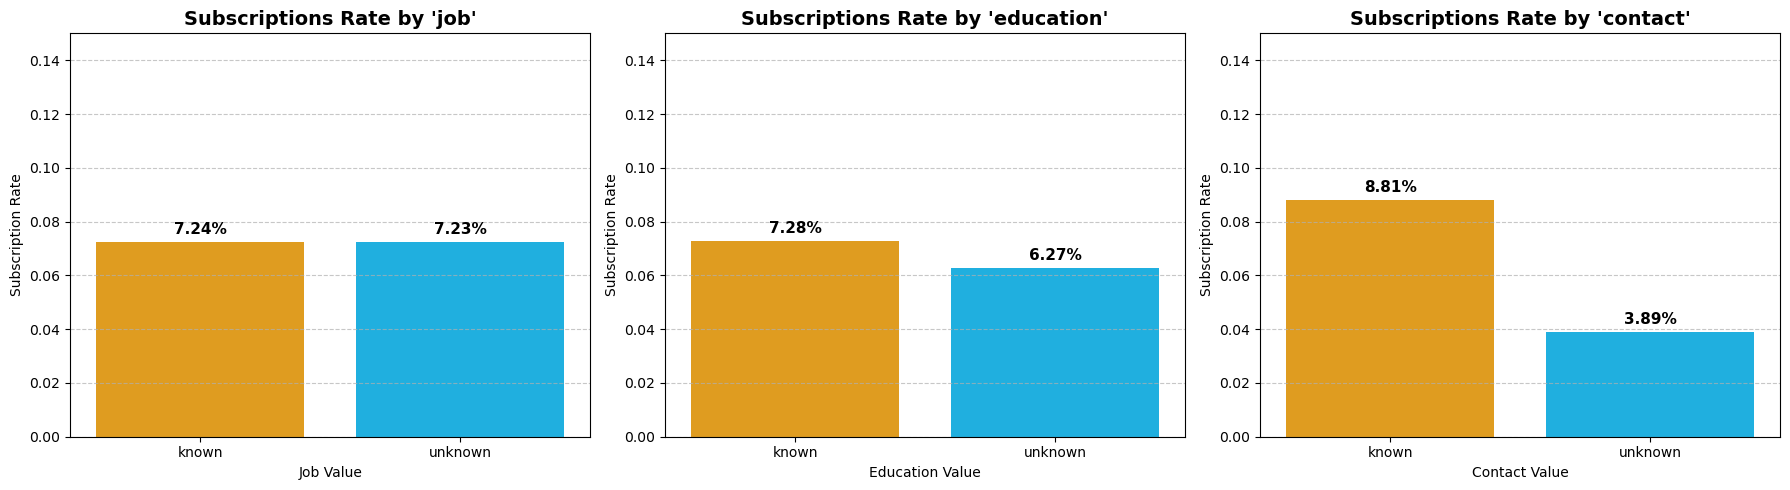

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unknowns(term_deposit):
    unknown_deposit = term_deposit.copy()
    # Convert target to binary
    unknown_deposit["y"] = unknown_deposit["y"].map({"yes": 1, "no": 0})

    # features that contain unknown values
    unknown_features = ['job','education','contact']

    # loop creates new binary columns that indicate whether each row in a feature has unknown value
    """
    - Creates a new binary column for each feature (e.g., job_unknown)
    - True : if the row has value `unknown`
    - False : otherwise
    This allows comparsion between "known" vs "unknown" groups.
    """
    for feature in unknown_features:
        unknown_deposit[f"{feature}_unknown"] = unknown_deposit[feature] == 'unknown'

    # Create a 1x3 subplot grid
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    # Plot success rates (proportion of y=1) for 'unknown' vs 'known' in each feature
    for i, feature in enumerate(unknown_features):
        col = f"{feature}_unknown"
        # compute the average of y (subscription) for each T/F group
        rate_term_deposit = unknown_deposit.groupby(col)["y"].mean().reset_index()
        # Relabel True and False
        rate_term_deposit[col] = rate_term_deposit[col].map({True: "unknown", False: "known"})

        ax = axes[i]
        ax = sns.barplot(data=rate_term_deposit, x=col, y="y", hue=col, palette=["orange", "deepskyblue"], legend=False, ax=ax)

         # Add percentage labels above bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 0.003,
                    f'{height * 100:.2f}%', ha="center", fontsize=11, fontweight='bold')
            
        ax.set_title(f"Subscriptions Rate by '{feature}'", fontsize=14, fontweight='bold')
        ax.set_ylabel('Subscription Rate')
        ax.set_xlabel(f'{feature.capitalize()} Value')
        ax.set_ylim(0,0.15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_unknowns(term_deposit)

The percentage of unknown jobs for the category jobs is 0.6%. The total count of unknowns (235) is relatively small so I will keep these rows. From the subscription rate for known and unknown jobs, we see that people who do not disclose their jobs are slightly less likely to subscribe.  

Those with an unknown education have a lower subscription rate of 6.27% compared to known 7.28%. This significant lower subscription rate implies those with unknown education are less financially engaged or less responsive.  

Unknown contacts make up 32% which is a substantial amount of the contacts feature and would not be viable to be dropped from the dataset. Those with unknown contact means have a subscription rate of 3.89% compared to 8.81% This difference suggests that contact type is a meaningful signal. I will keep unknown as a valid level in one-hot encoding instead of imputing or removing this unknown values from the features.


#### Correlation heat map:  

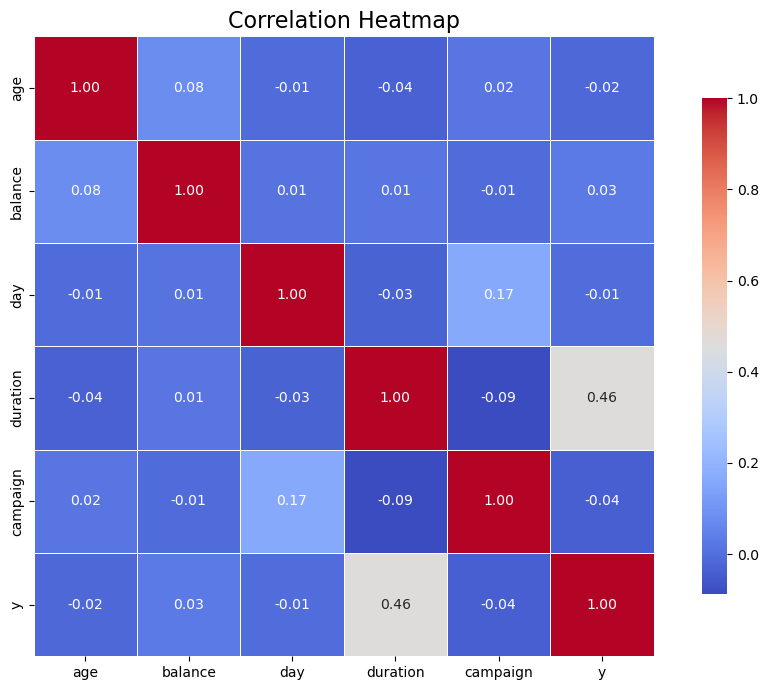

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap ofr 
def heatmap(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_deposit['y'] = correlation_deposit['y'].map({'yes':1, 'no':0})
    correlation_matrix = correlation_deposit.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap(term_deposit)

There is notable correlation between duration and target variable. Very little correlations between each othe features, implies they are independent. No major colinearity among the freatures. 

#### Feature Distributions Numerical
The following plots display the skewness value, histogram shape and Q-Q plot shape for each of the numerical features in the dataset. Q-Q plots, histograms, and skewness values are used to understand the shape and symmetry of the feature distributions in order to decide how I would preprocess features before modeling. The histogram plots will show the distribution of values for the numerical features to give a visual overview of how a feature is spread across its range. The skewness value measures the asymmetry of a distribution. A normal distribution has a skewness ~ 0, a positive skew (right-skewed) visually has a long tail on the right (high values), and a negative skew (left-skewed) visually has a long tail on the left (low values). Quantile-Quantile (QQ) plots were utilized as a graphical tool to compare the distribution of the feature dataset against the normal distribution. Ideally the points should fall roughly on a straight line for the data to approximately be normally distributed. Some models (Logistic Regression, SVM and KNN) assume features are normally distributed and strong skewness or outliers can break these model’s performance.   

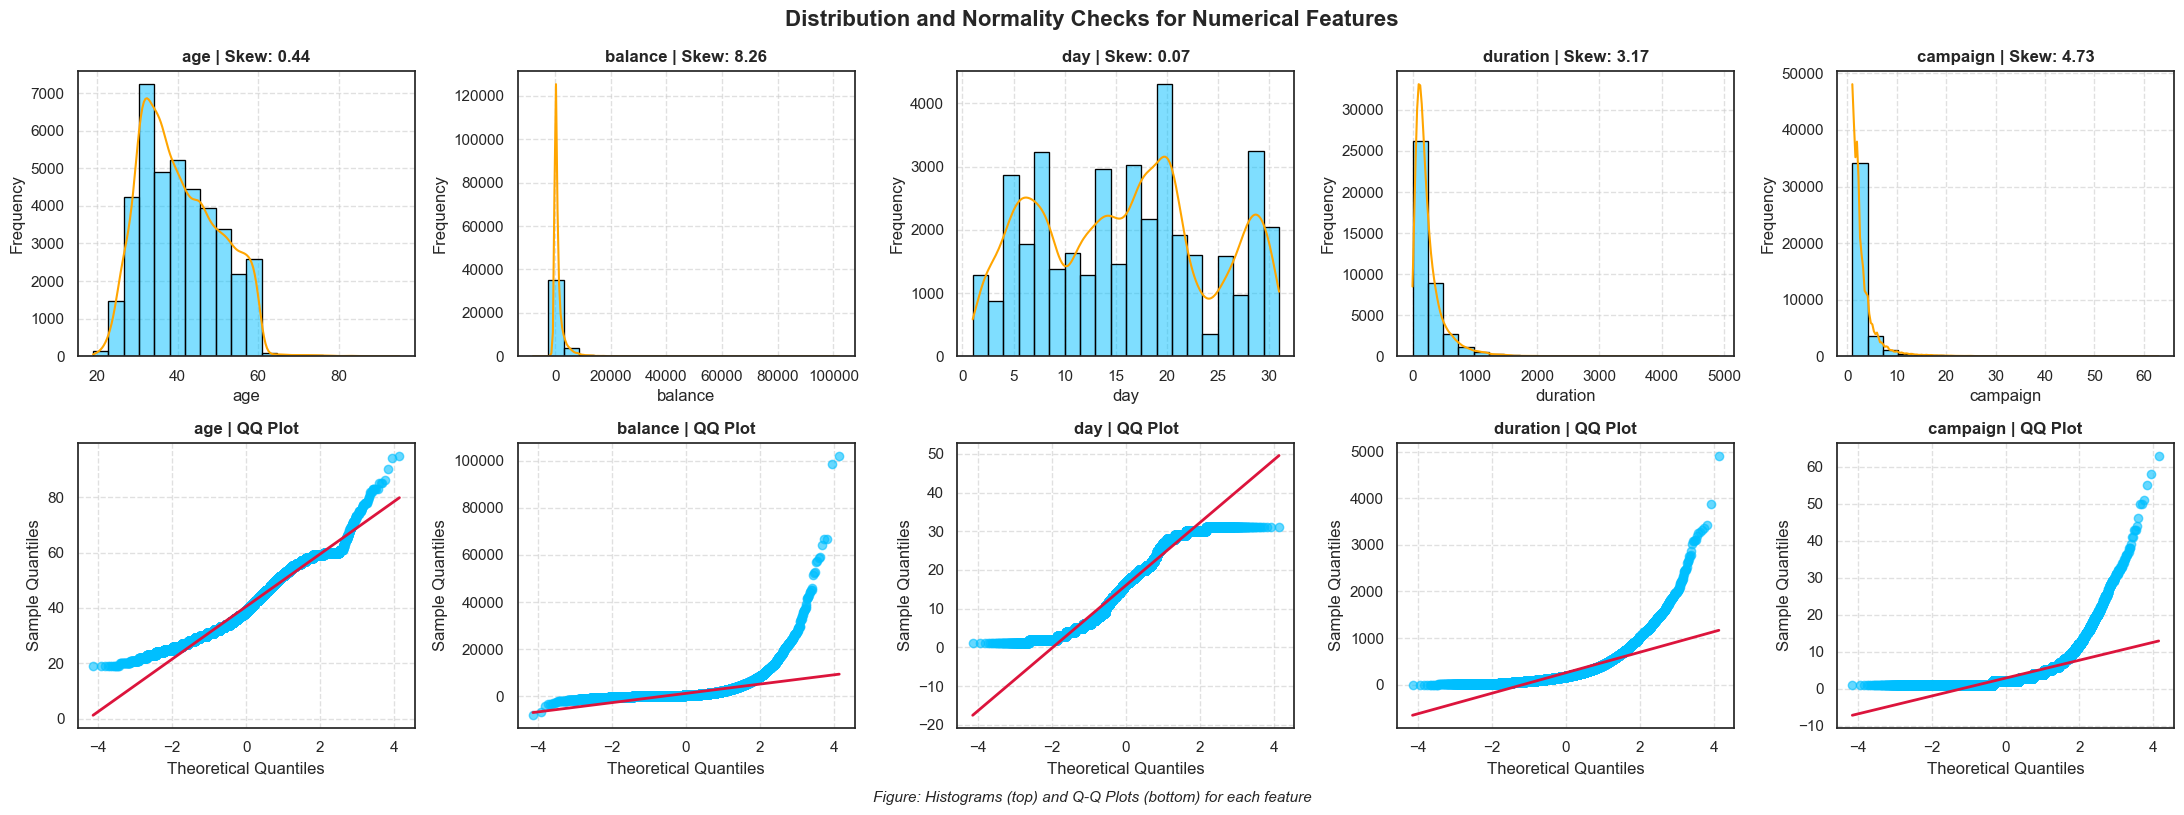

In [31]:
import scipy.stats as stats

# Updated function with bright blue QQ scatterpoints and custom KDE line
def check_skewness_and_qqplots(term_deposit, numerical_cols):
    sns.set_theme(style="white")
    fig, axes = plt.subplots(2,5, figsize=(22,8))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        skew_val = term_deposit[col].skew()

        # Histogram with KDE and custom colors
        sns.histplot(term_deposit[col], bins=20, kde=True, ax=axes[i],
                     color='deepskyblue', edgecolor='black', stat='count')

        # Modify KDE line color manually if present
        if axes[i].lines:
            axes[i].lines[0].set_color('orange')  # change KDE line color

        axes[i].set_title(f'{col} | Skew: {skew_val:.2f}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True, linestyle='--', alpha=0.6)

        # QQ Plot with bright blue scatterpoints and crimson line
        (osm, osr), (slope, intercept, r) = stats.probplot(term_deposit[col], dist="norm")

        axes[i+5].scatter(osm, osr, color='deepskyblue', alpha=0.6)
        axes[i+5].plot(osm, slope * osm + intercept, color='crimson', linewidth=2)
        axes[i+5].set_title(f'{col} | QQ Plot', fontsize=12, fontweight='bold')
        axes[i+5].set_xlabel("Theoretical Quantiles")
        axes[i+5].set_ylabel("Sample Quantiles")
        axes[i+5].grid(True, linestyle='--', alpha=0.6)

    # Adjust layout
    fig.suptitle("Distribution and Normality Checks for Numerical Features", fontsize=16, fontweight='bold')
    #fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.text(0.5, -0.01, 'Figure: Histograms (top) and Q-Q Plots (bottom) for each feature', 
             ha='center', fontsize=11, style='italic')
    plt.tight_layout()
    plt.show()

# Run the customized function
check_skewness_and_qqplots(term_deposit, numerical_cols)

The following can be gleaned for each numerical feature from the prior plots:  

* **age**:  The age variable histogram shows a small tail to the right with a mild slightly positive (right-skewed) value. Age’s QQ plot has the deviated points curving upward confirming the data is right-skewed. Most customers are in their 30s or middle aged with a tail to older years. Interpretation leads to this variable being almost normal with no transformations needed.  

* **balance**: Feature *balance*’s skewness value is very high (~8.9) and its histogram shows a long right tail with many small values and a few large outliers. The feature is strongly right skewed and its QQ plot having heavy S-shaped deviations in upper quantiles. Interpretation of these plots leads to the consideration of using log transformation to reduce skewness before modeling. Most customers have small to moderate balances, but few customers have very large balances pulling the distribution’s tail far to the right.  

* **day**: This variable has little to no skewness. The distribution of the days is fairly uniform across the month, with no strong pattern or bias toward the beginning or end.  

* **duration**: This feature has most of its values concentrated on the left with a sharp right tail. It has a high right-skewed value. From its QQ plot, it has a severe deviation from normality at higher values. Most calls are short but there are a few calls that are very long. Logarithmic transformation will be done on this feature with a cap on long calls to prevent distorting models.  

* **campaign**: Campaign has a high right-sided skewness value where the majority of the clients were contacted a few times and a few outliers were contacted 10+ times. The QQ plot affirms outliers affect the upper quantities. Will cap the long outliers to prevent noise.   


#### Feature Distributions Categorical

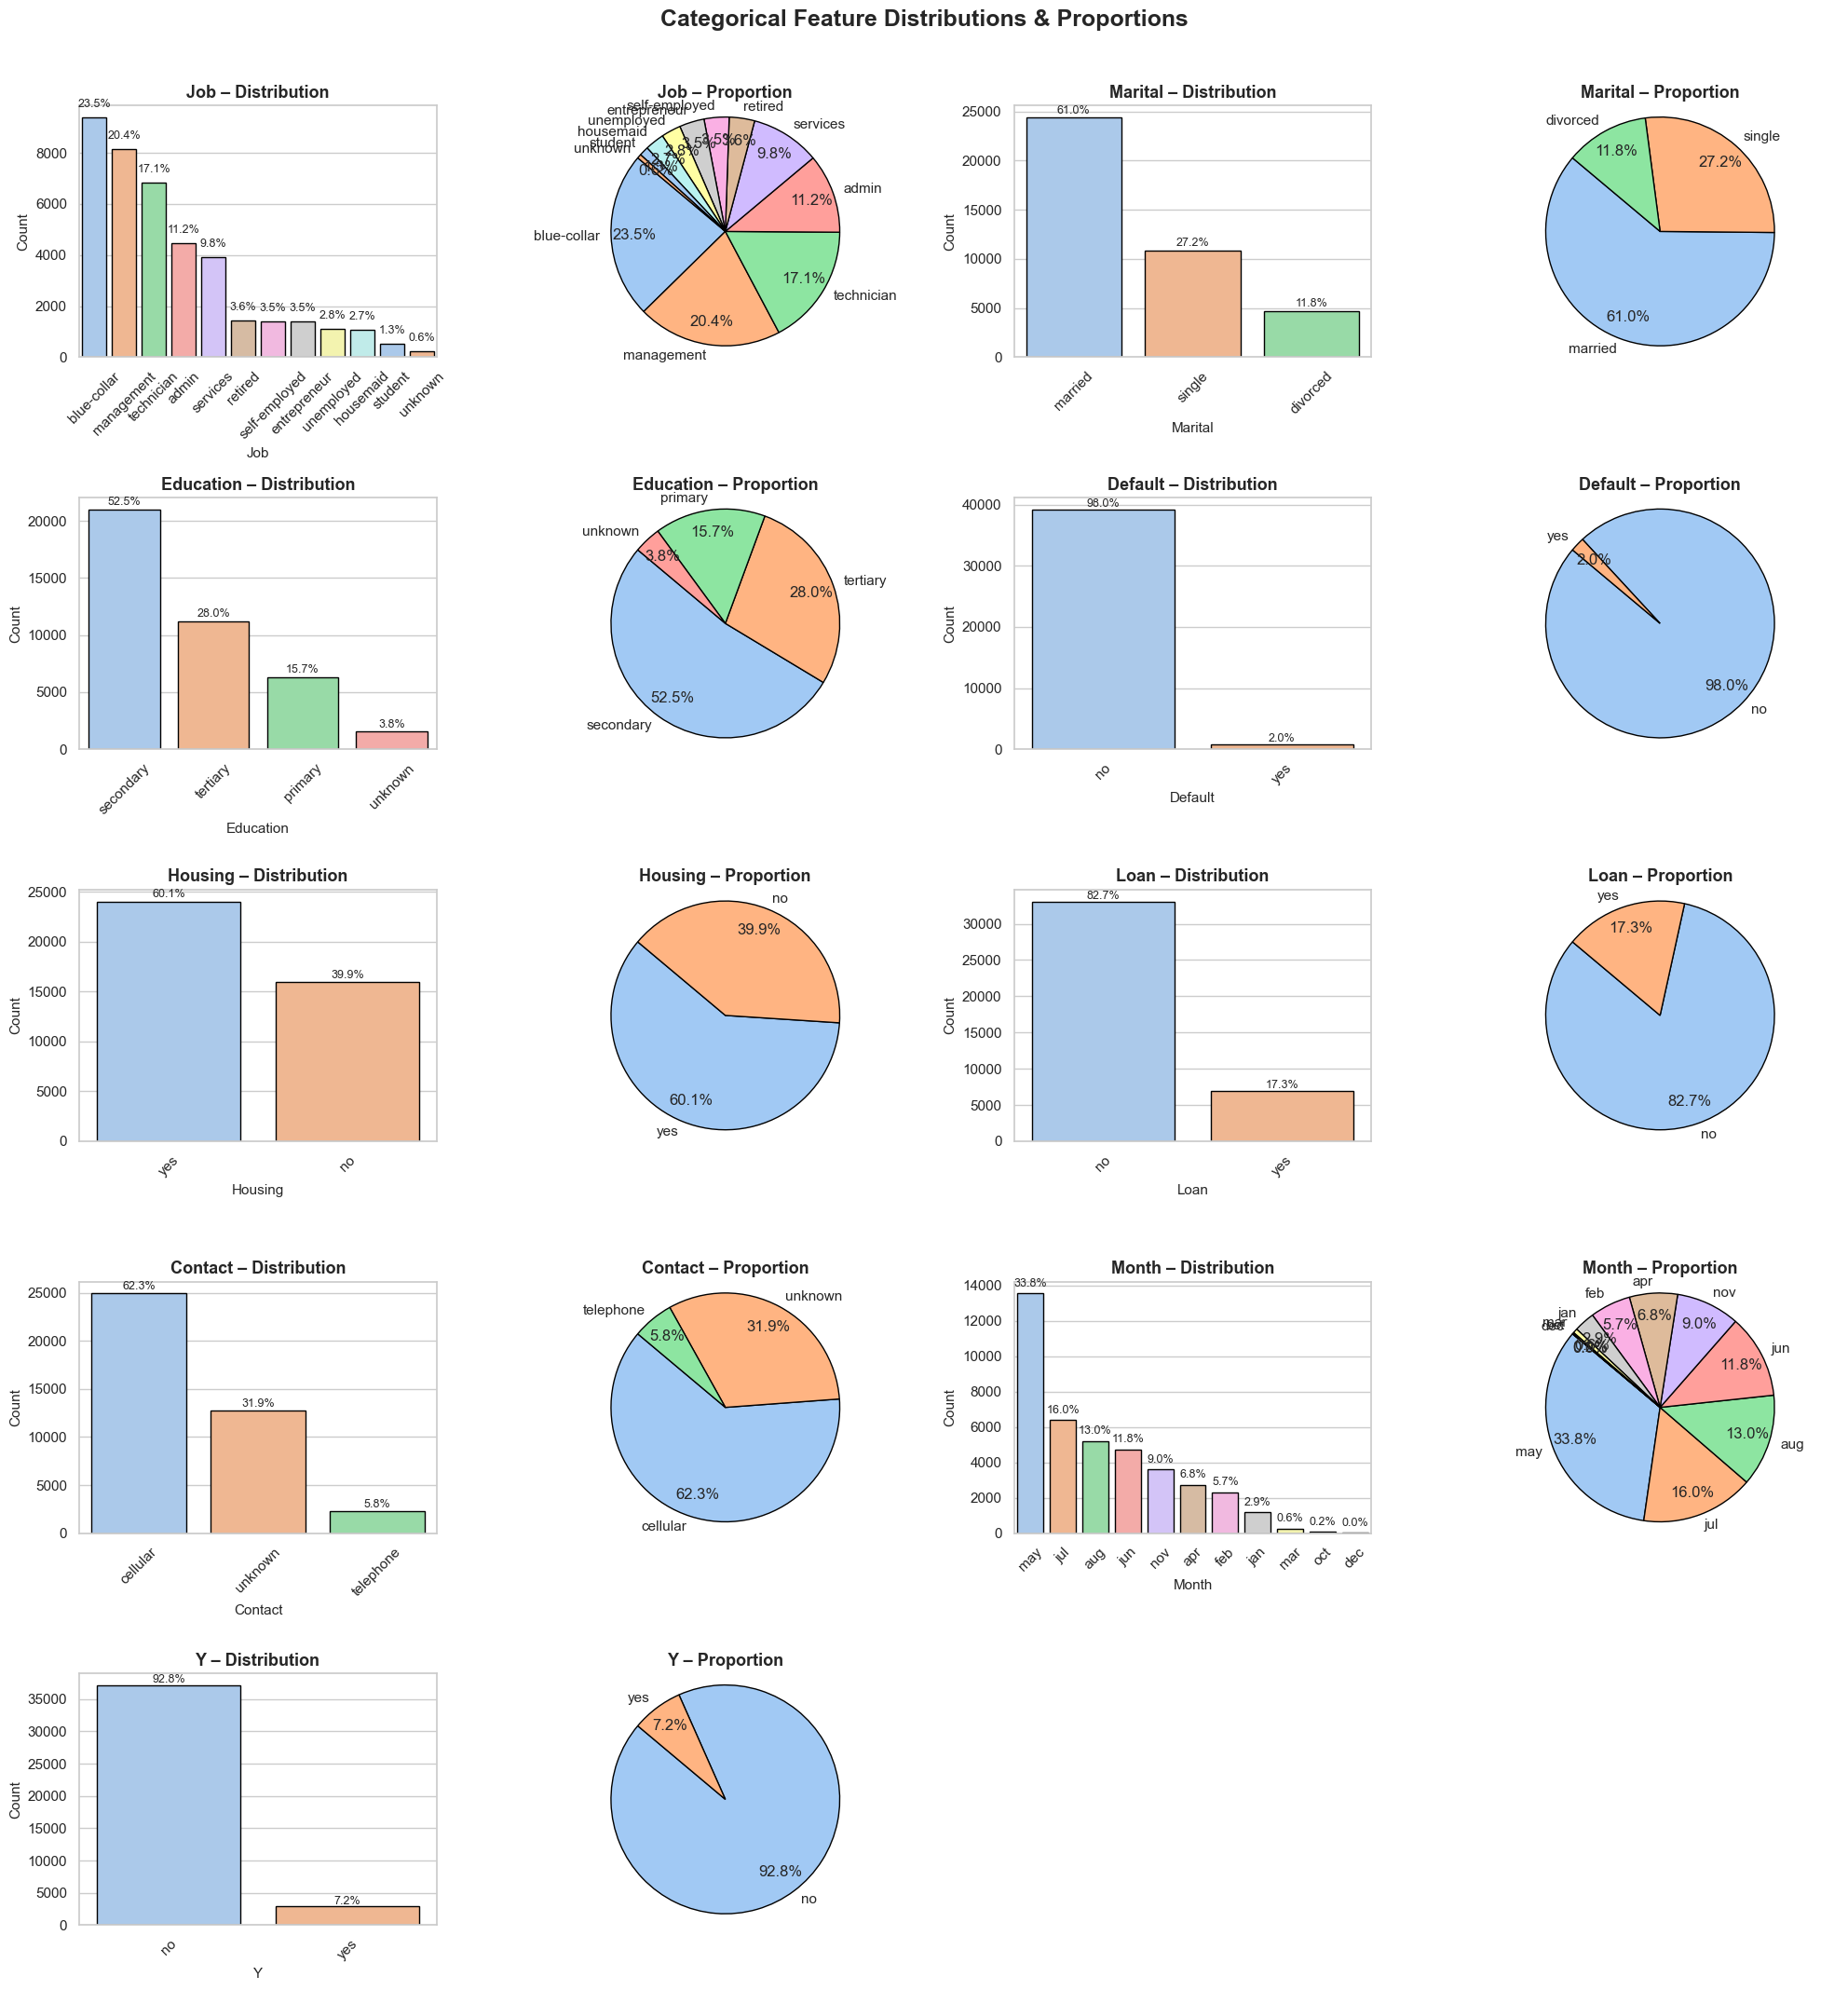

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')


# function to plot bar and pie charts for categorical features in the dataset
def plot_categorical_eda(term_deposit ,categorical_cols):
    """
    Plots bar and pie charts for categorical features in a 5x4 grid layout.
    Parameters:
    term_deposit : 
        The dataset containing categorical features.
    categorical_cols : 
        List of categorical column names to plot 
    """
    color_palette = sns.color_palette('pastel')
    # number of rows in dataset used to compute percentages
    total = len(term_deposit)
    num_features = len(categorical_cols)

    # Set up the 5x4 grid (each feature takes 2 plots: bar and pie)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 22))
    axes = axes.flatten()

    # Main Plotting Loop
    for i, col in enumerate(categorical_cols):
        # assign bar+pie plots next to each other, 
        bar_ax = axes[2*i]
        pie_ax = axes[2*i+1]

        # Count of each category, preprocessing per column
        value_counts = term_deposit[col].value_counts()
        percentages = (value_counts / total * 100).round(1)

        # Bar Plot Construction
        sns.countplot(
            data=term_deposit,
            x=col,
            order=value_counts.index,
            palette=color_palette,
            ax = bar_ax,
            edgecolor='black'
        )
        # Add percentage labesl above bars
        for j, count in enumerate(value_counts):
            bar_ax.text(j, count + total * 0.01, f'{(count / total * 100):.1f}%', 
                        ha='center', fontsize=9)
        bar_ax.set_title(f'{col.capitalize()} – Distribution', fontsize=13, fontweight='bold')
        bar_ax.set_xlabel(col.capitalize(), fontsize=11)
        bar_ax.set_ylabel("Count", fontsize=11)
        bar_ax.tick_params(axis='x', rotation=45)

        # ---- Pie Chart ----
        pie_ax.pie(
            value_counts,
            labels=value_counts.index,
            autopct='%1.1f%%',
            pctdistance=0.8,
            startangle=140,
            colors=color_palette,
            wedgeprops={'edgecolor': 'black'}
        )
        pie_ax.set_title(f'{col.capitalize()} – Proportion', fontsize=13, fontweight='bold')
        pie_ax.axis('equal')

    # Remove unused axes if any
    for idx in range(2 * num_features, len(axes)):
        fig.delaxes(axes[idx])

    fig.suptitle("Categorical Feature Distributions & Proportions", fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()
        
plot_categorical_eda(term_deposit, categorical_cols)

The following insights can be gleaned from the prior bar and pie charts of the categorical features: 
* **Y**: From the last plot, the distribution of the target variable is heavily imbalanced. Most customers did not subscribe to the term deposit with a subscription rate ~ 7%. Synthetic Minority Over-sampling Technique (SMOTE) will be utilized to handle the imbalance, and the evaluation metric will be adjusted to focus on F1-score instead of accuracy.  

* **Job**: The most common jobs are blue-collar, management, technician, admin and services. Students and retired customers are less frequent but are important as they often show higher subscription rates.

* **Marital**: Most customers are married (*61%*) followed by single and divorced. There is no major imbalance.

* **Education**: Over half of the customer base has a secondary level of education (*52.25%*), followed by tertiary, primary and lastly unknown. 

* **Default**: The vast majority of customers do not have default (96%). This feature is highly imbalanced.
 
* **Housing**: This feature is balanced, with ~60% of the customers having a housing loan. 

* **Loan**: Most customers do not have a personal loan (82.7%). This feature might be useful as having personal loans may impact financial flexibility.

* **Contact**: Majority of contact methods have been via cellular (623%) with unknown following and telephone having a small part. The unknown category is kept as it may indicate poor campaign reach.

* **Month**: From the plots, most calls are made in May, July, August and June. Months like January, March, October and December have very low marketing efforts. Seasonality is important and this feature will be cyclically encoded.


#### Detecting Outliers:  
Interquantile Range (IQR) was used to detect outliers for the numerical features. Many of the numerical features (balance, duration and campaign) are strongly skewed and not normally distributed from the histrogram and QQ plots. IQR focuses on the middle 50% of the data and ignores the extreme values on both ends. This makes it resistant to extreme outliers. 

In [3]:
# Outlier detection using IQR
# identifies and counts the number of outliers in each numerical column of the dataset using the Interquartile Range Method
def detect_outliers_iqr(term_deposit, numerical_cols):
    # compute the 25th and 75th percentile for each numerical column
    Q1 = term_deposit[numerical_cols].quantile(0.25)
    Q3 = term_deposit[numerical_cols].quantile(0.75)
    # calculates the Interquartile range "middle 50%"
    IQR = Q3 - Q1
    # threshold limits of an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # checks for each column which rows fall outside the bounds
    outliers = ((term_deposit[numerical_cols] < lower_bound) | (term_deposit[numerical_cols] > upper_bound)).sum()
    print(outliers[outliers>0])
    

detect_outliers_iqr(term_deposit,numerical_cols)


age           79
balance     4280
duration    3000
campaign    2992
dtype: int64


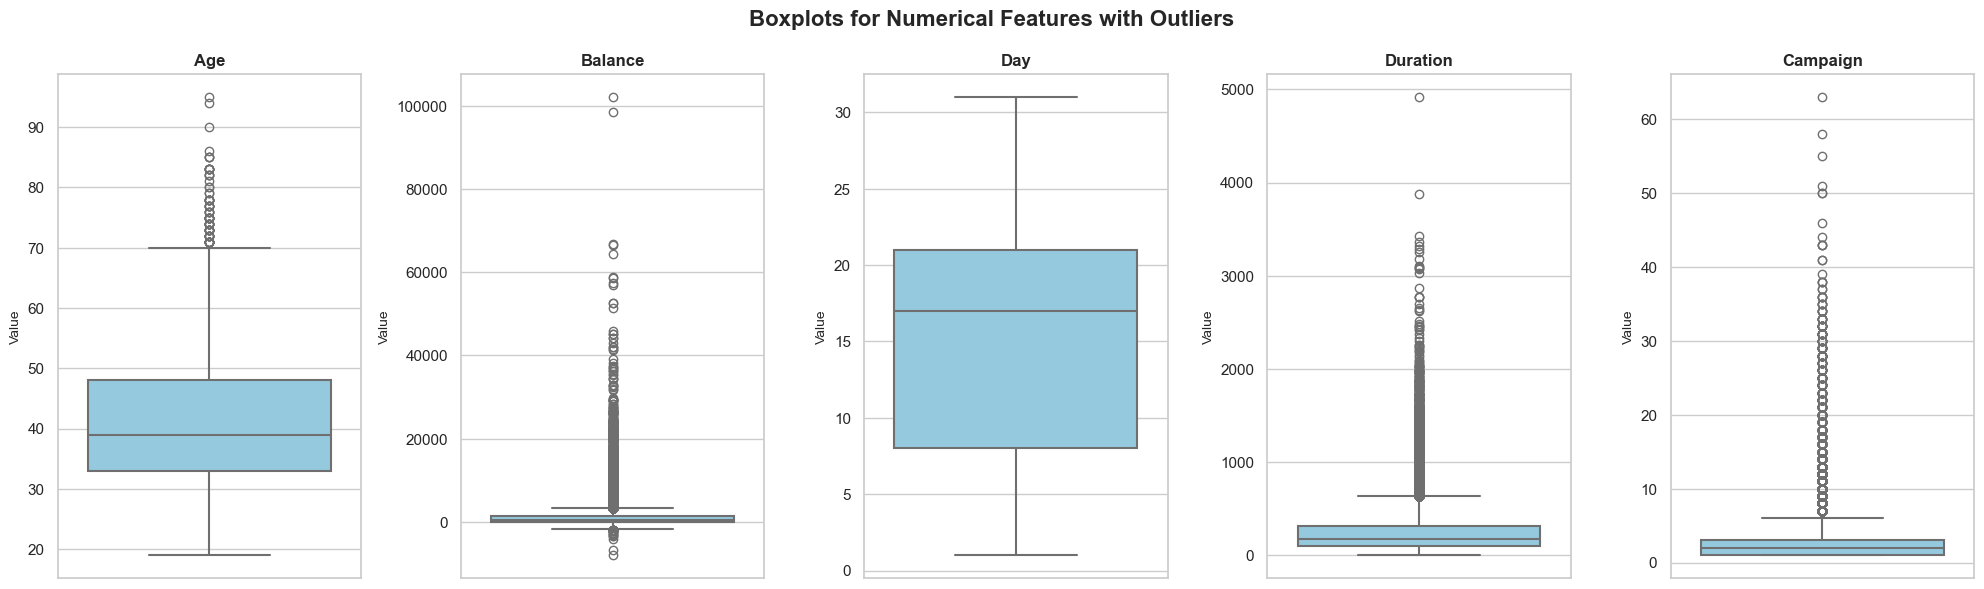

In [ ]:
# boxplot visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_outliers(term_deposit, numerical_cols):
    sns.set_theme(style='whitegrid')
    
    #plt.figure(figsize=(8,4))
    num_features = len(numerical_cols)
    # create subplots, arrange boxplots horizontally (1 row, n columns)
    # each subplot is width 4, height 6, and sharey=False means each plot has it owns y-axis
    fig, axs = plt.subplots(1,num_features, figsize=(4 * num_features, 6), sharey=False)
    for i, num in enumerate(numerical_cols):
        sns.boxplot(y=term_deposit[num], ax=axs[i], color = 'skyblue', linewidth=1.5)
        axs[i].set_title(f"{num.capitalize()}", fontsize=12, fontweight='bold')
        axs[i].set_ylabel('Value', fontsize=10)
    fig.suptitle('Boxplots for Numerical Features with Outliers', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

boxplot_outliers(term_deposit, numerical_cols)

#### Overall Insights from numerical features boxplots
* Significant number of outliers in features: Balance, Duration and Campaign. These boxplots confirm from previous findings that these features will need transformation done to them. *Balance* contains negative values (overdrafts) which will be need to be shifted when log transformed as log transforming negative values produce NaN values which will crash machine learning models.
* The outliers in age are natural as there are older customers. Day has no significant outliers. 

### Preprocessing:  
##### One-hot Encoding to handle different data type features (categorical and numerical):  
One-hot encoding is a method to convert categorical features into a numerical format that machine learning models can utlizie. Simply assigning numbers to categories (e.g. job: 'staff' = 2, 'scientist' = 5) can mislead our ML models to think there is an ordinal relationship. The term deposit dataset shown above has 13 features and 40,000 data point of which 9 of the features are categorical. 


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def convert_object_features(df):
    """ 
    Identify all object type columns and splits them into binary and categorical features.
    Encodes binary features using LabelEncoder to 0 and 1. 
    Casts categorical features to category dtype
    """
    df = df.copy()

    # Exclude the target variable
    object_cols = df.select_dtypes(include='object')

    # Define binary and categorical features
    binary_features = []
    categorical_features = []

    for col in object_cols:
        unique_vals = df[col].nunique()
        if unique_vals == 2:
            binary_features.append(col)
        else:
            categorical_features.append(col)

    # Convert binary features to 0/1
    for col in binary_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype('int64')

    # converting categorical features to dummy variables
    df[categorical_features] = df[categorical_features].astype('category')

    return df

term_deposit_changed = convert_object_features(term_deposit)
term_deposit_changed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        40000 non-null  int64   
 1   job        40000 non-null  category
 2   marital    40000 non-null  category
 3   education  40000 non-null  category
 4   default    40000 non-null  int64   
 5   balance    40000 non-null  int64   
 6   housing    40000 non-null  int64   
 7   loan       40000 non-null  int64   
 8   contact    40000 non-null  category
 9   day        40000 non-null  int64   
 10  month      40000 non-null  category
 11  duration   40000 non-null  int64   
 12  campaign   40000 non-null  int64   
 13  y          40000 non-null  int64   
dtypes: category(5), int64(9)
memory usage: 2.9 MB


In [3]:
def print_columns_with_unknowns(df):
    for col in df.columns:
        if 'unknown' in df[col].values:
            count = (df[col] == 'unknown').sum()
            percentage = round(count / df.shape[0] * 100, 2)
            print('-----------------------------------')
            print(f"{col} : {count}")
            print(f"Percentage of unknown values in {col} : {percentage}%")
            print(f"Unique values of {col} : {df[col].unique()}")

print_columns_with_unknowns(term_deposit_changed)

-----------------------------------
job : 235
Percentage of unknown values in job : 0.59%
Unique values of job : ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student', 'technician', 'unemployed', 'unknown']
-----------------------------------
education : 1531
Percentage of unknown values in education : 3.83%
Unique values of education : ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary', 'secondary', 'tertiary', 'unknown']
-----------------------------------
contact : 12765
Percentage of unknown values in contact : 31.91%
Unique values of contact : ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular', 'telephone', 'unknown']


In [4]:
def handle_unknown_values(df, lower_thresh=5.0, upper_thresh=30.0):
    df = df.copy()
    total_rows = df.shape[0]

    for col in df.columns:
        if 'unknown' in df[col].values:
            unknown_count = (df[col] == 'unknown').sum()
            unknown_pct = unknown_count / total_rows * 100

            if unknown_pct < lower_thresh:
                df = df[df[col] != 'unknown']  # Drop rows
            elif unknown_pct <= upper_thresh:
                # Impute with mode
                mode_val = df[col].mode()[0]
                df[col] = df[col].replace('unknown', mode_val)
            else:
                # Optionally drop column if unknowns are too frequent
                df.drop(columns=col, inplace=True)

    return df


term_deposit_unknown_removed = handle_unknown_values(term_deposit_changed)

In [6]:
term_deposit_unknown_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        38338 non-null  int64   
 1   job        38338 non-null  category
 2   marital    38338 non-null  category
 3   education  38338 non-null  category
 4   default    38338 non-null  int64   
 5   balance    38338 non-null  int64   
 6   housing    38338 non-null  int64   
 7   loan       38338 non-null  int64   
 8   day        38338 non-null  int64   
 9   month      38338 non-null  category
 10  duration   38338 non-null  int64   
 11  campaign   38338 non-null  int64   
 12  y          38338 non-null  int64   
dtypes: category(4), int64(9)
memory usage: 3.1 MB


### Feature engineering:

# One hot encoding

In [5]:
import numpy as np
import pandas as pd

def encode_categorical_features(df):
    df = df.copy()

    # Ordinal encoding for 'education'
    education_order = ['primary', 'secondary', 'tertiary']
    df['education'] = df['education'].astype(pd.api.types.CategoricalDtype(categories=education_order, ordered=True))
    df['education'] = df['education'].cat.codes

    # One-hot encode 'job' and 'marital'
    df['job'] = df['job'].cat.remove_unused_categories()
    df = pd.get_dummies(df, columns=['job', 'marital'], drop_first=True)

    # Convert 'month' from categorical to string before mapping
    df['month'] = df['month'].astype(str).str.lower()
    month_map = {
        'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
        'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
        'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
    }
    df['month'] = df['month'].map(month_map).astype(int)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df.drop(columns='month', inplace=True)

    return df

term_deposit_preprocessed = encode_categorical_features(term_deposit_unknown_removed)

In [9]:
term_deposit_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                38338 non-null  int64  
 1   education          38338 non-null  int8   
 2   default            38338 non-null  int64  
 3   balance            38338 non-null  int64  
 4   housing            38338 non-null  int64  
 5   loan               38338 non-null  int64  
 6   day                38338 non-null  int64  
 7   duration           38338 non-null  int64  
 8   campaign           38338 non-null  int64  
 9   y                  38338 non-null  int64  
 10  job_blue-collar    38338 non-null  bool   
 11  job_entrepreneur   38338 non-null  bool   
 12  job_housemaid      38338 non-null  bool   
 13  job_management     38338 non-null  bool   
 14  job_retired        38338 non-null  bool   
 15  job_self-employed  38338 non-null  bool   
 16  job_services       38338 no

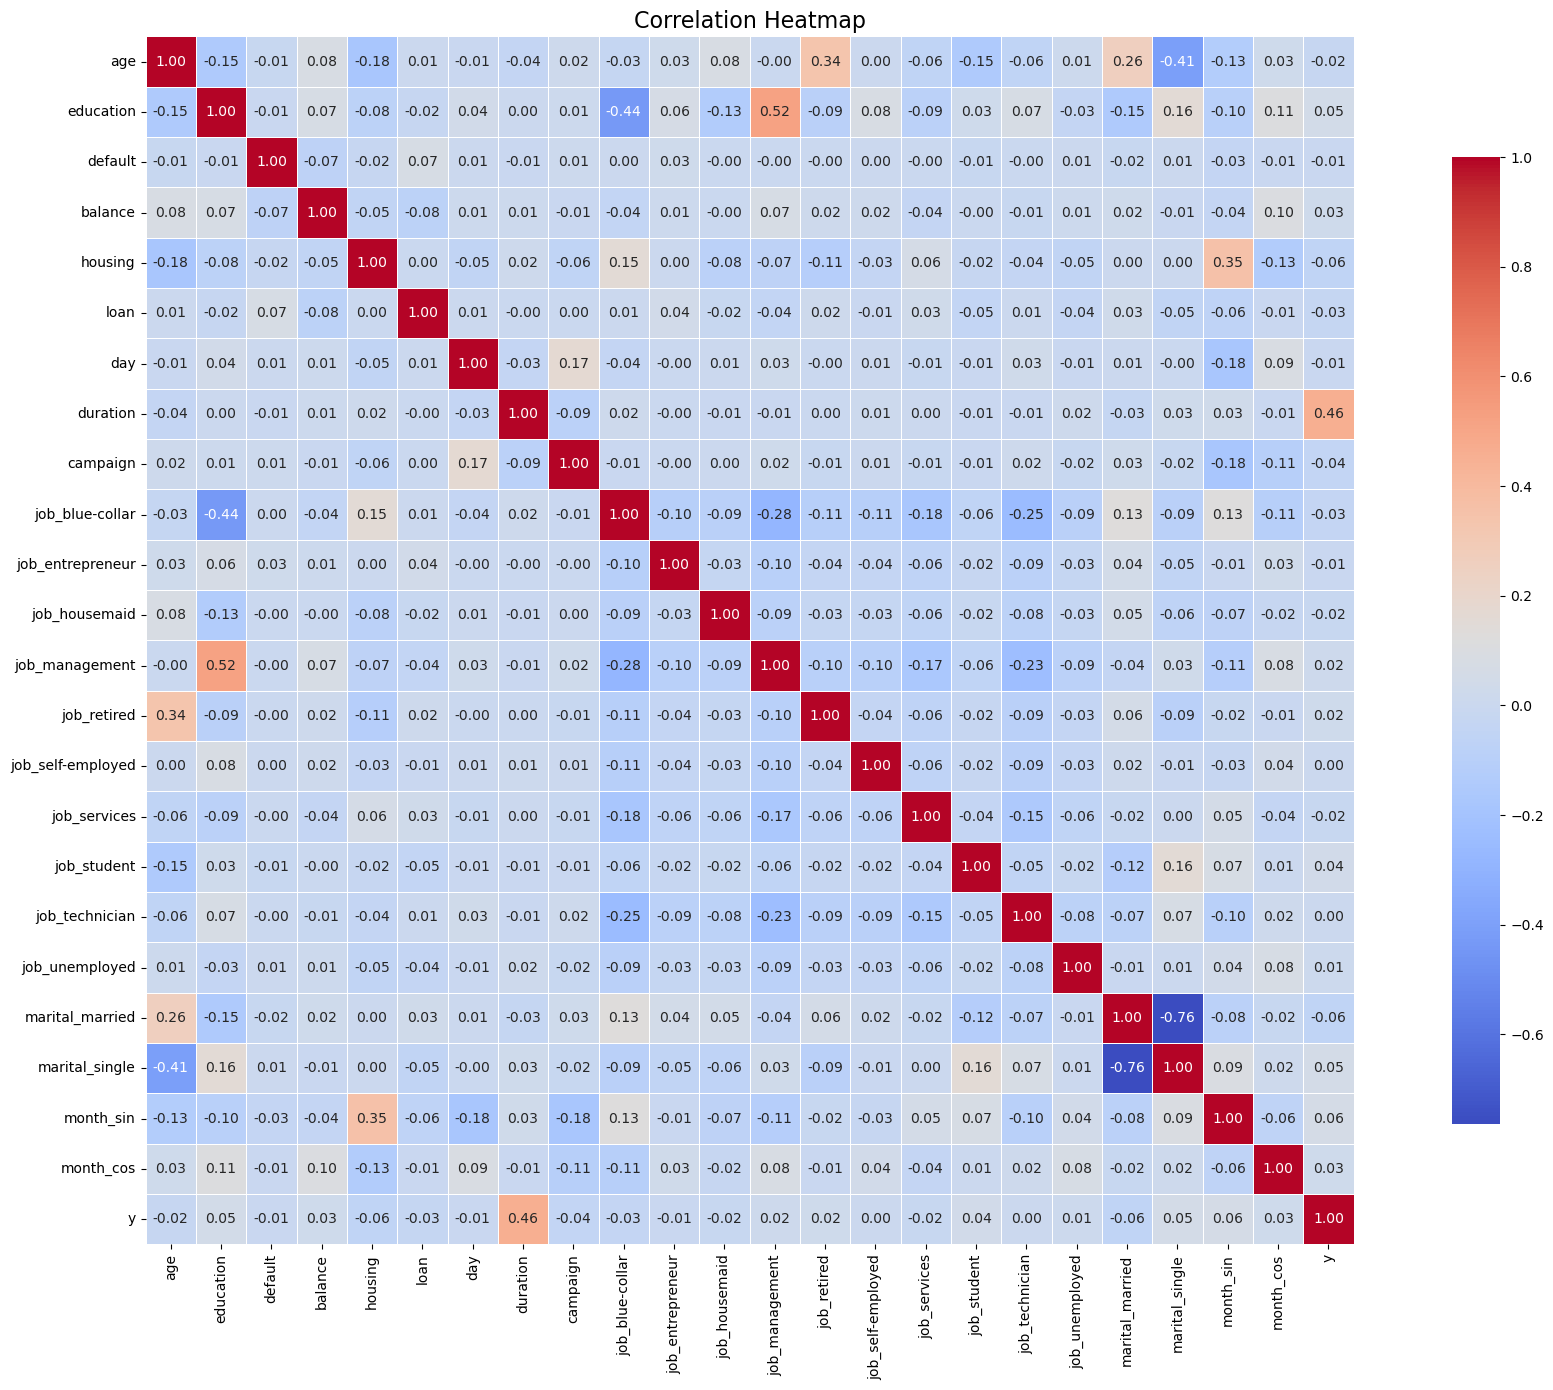

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_new(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_matrix = correlation_deposit.corr()

    # Move 'y' to the end (both rows and columns)
    cols = [col for col in correlation_matrix.columns if col != 'y'] + ['y']
    correlation_matrix = correlation_matrix.loc[cols, cols]

    fig, ax = plt.subplots(figsize=(20,14))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
    )

    ax.set_title("Correlation Heatmap", fontsize=16)
    fig.tight_layout()
    plt.show()

# Example call
heatmap_new(term_deposit_preprocessed)


In [6]:
def drop_low_correlation_features(df, target_column='y', threshold=0.01):
    """
    Drops features from df that have low linear correlation with the target variable.

    Parameters:
    - df (pd.DataFrame): Dataset including the target column
    - target_column (str): Name of the target variable
    - threshold (float): Minimum absolute correlation value to keep a feature

    Returns:
    - df_filtered (pd.DataFrame): Dataset with low-correlation features removed
    """
    corr_matrix = df.corr()
    target_corr = corr_matrix[target_column].drop(target_column)

    low_corr_features = target_corr[(-threshold < target_corr) & (target_corr < threshold)].index.tolist()
    df_filtered = df.drop(columns=low_corr_features)

    print(f"Dropped {len(low_corr_features)} features with |correlation| < {threshold}:")
    print(low_corr_features)

    return df_filtered

term_deposit_changed_v2 = drop_low_correlation_features(term_deposit_preprocessed)

Dropped 6 features with |correlation| < 0.01:
['default', 'day', 'job_entrepreneur', 'job_self-employed', 'job_technician', 'job_unemployed']


In [9]:
def cap_outliers_iqr(series, name=None):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    capped = np.clip(series, lower, upper)
    if name:
        num_capped = ((series < lower) | (series > upper)).sum()
        print(f"{name}: {num_capped} values capped using IQR.")
    return capped

def transform_skewed_features(df):
    df = df.copy()

    # Shift balance to ensure positivity for log transformation
    if (df['balance'] <= 0).any():
        df['balance'] = df['balance'] + abs(df['balance'].min()) + 1
    df['balance'] = np.log(df['balance'])

    # Log-transform duration
    df['duration'] = np.log(df['duration'] + 1)

    # Cap campaign at 10, then log-transform
    df['campaign'] = np.where(df['campaign'] > 10, 10, df['campaign'])
    df['campaign'] = np.log(df['campaign'] + 1)

    # Cap outliers after log transformations
    df['balance'] = cap_outliers_iqr(df['balance'], name='balance')
    df['duration'] = cap_outliers_iqr(df['duration'], name='duration')
    df['campaign'] = cap_outliers_iqr(df['campaign'], name='campaign')

    return df

term_deposit_changed_v3 = transform_skewed_features(term_deposit_changed_v2)

balance: 3592 values capped using IQR.
duration: 962 values capped using IQR.
campaign: 0 values capped using IQR.


In [10]:
term_deposit_changed_v3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38338 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              38338 non-null  int64  
 1   education        38338 non-null  int8   
 2   balance          38338 non-null  float64
 3   housing          38338 non-null  int64  
 4   loan             38338 non-null  int64  
 5   duration         38338 non-null  float64
 6   campaign         38338 non-null  float64
 7   y                38338 non-null  int64  
 8   job_blue-collar  38338 non-null  bool   
 9   job_housemaid    38338 non-null  bool   
 10  job_management   38338 non-null  bool   
 11  job_retired      38338 non-null  bool   
 12  job_services     38338 non-null  bool   
 13  job_student      38338 non-null  bool   
 14  marital_married  38338 non-null  bool   
 15  marital_single   38338 non-null  bool   
 16  month_sin        38338 non-null  float64
 17  month_cos        

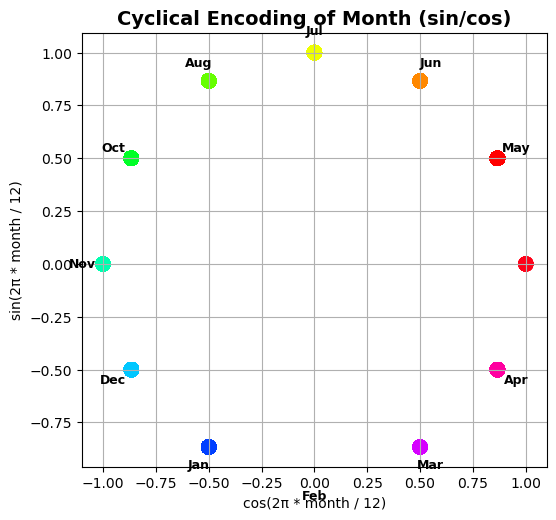

In [22]:
import matplotlib.pyplot as plt

def plot_month_cyclical_encoding(term_deposit):
    # Ensure month has not been dropped yet
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                   'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    term_deposit['month_num'] = term_deposit['month'].str.lower().map({m: i+1 for i, m in enumerate(month_order)})
    term_deposit['month_sin'] = np.sin(2 * np.pi * term_deposit['month_num'] / 12)
    term_deposit['month_cos'] = np.cos(2 * np.pi * term_deposit['month_num'] / 12)

    plt.figure(figsize=(6,6))
    plt.scatter(term_deposit['month_cos'], term_deposit['month_sin'], c=term_deposit['month_num'], cmap='hsv', s=100)
    
    for i, txt in enumerate(term_deposit['month'].unique()):
        angle = 2 * np.pi * (i + 1) / 12
        x = np.cos(angle)
        y = np.sin(angle)
        plt.text(x * 1.1, y * 1.1, txt.capitalize(), ha='center', va='center', fontsize=9, weight='bold')
    
    plt.title('Cyclical Encoding of Month (sin/cos)', fontsize=14, fontweight='bold')
    plt.xlabel('cos(2π * month / 12)')
    plt.ylabel('sin(2π * month / 12)')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_month_cyclical_encoding(term_deposit)

### Train/Test Split Transformed Dataset


In [11]:
from sklearn.model_selection import train_test_split


X = term_deposit_changed_v3.drop(columns='y')
y = term_deposit_changed_v3['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=369
)

### Feature Selection: Combining Statistical, Model-based, and Wrapper Methods

In any supervised machine learning task, selecting the most relevant features is essential for building performant and interpretable models. In this project, we employed a multi-pronged feature selection strategy encompassing filter, embedded, and wrapper methods to robustly identify the features most predictive of customer subscription to a term deposit.

1. Mutual Information (Filter Method)
Mutual Information measures the amount of information one variable provides about another. Unlike linear methods, it can detect non-linear dependencies between features and the target.

We used mutual_info_classif from scikit-learn, which estimates the mutual information between each feature and the binary target (yes or no subscription), helping us prioritize variables that share the most information with the outcome — even in complex, non-linear ways.

2. ANOVA F-Test (Filter Method)
The Analysis of Variance (ANOVA) F-test evaluates the degree to which the means of different groups (in this case, subscribers vs. non-subscribers) vary across feature values. It assumes a linear relationship between each feature and the target and is ideal for selecting features when using linear classifiers.

We used SelectKBest with f_classif, which ranks features based on their F-scores — a statistical measure of between-group vs. within-group variability.

3. L1-Regularized Logistic Regression (Embedded Method)
L1 regularization (also known as Lasso) not only penalizes large weights but also drives less informative feature coefficients to zero — effectively eliminating them. This is an embedded method, meaning the feature selection is part of the model training itself.

By fitting a logistic regression with an L1 penalty, we captured a sparse linear model, identifying which features most strongly contribute to the model’s predictive power.

4. Random Forest Feature Importance (Embedded Method)
Random Forests are ensembles of decision trees that naturally produce feature importances based on Gini impurity reduction — essentially quantifying how much each feature decreases node uncertainty when splitting.

This method is particularly effective in handling non-linearities and interactions between features, making it ideal in real-world datasets like ours with both numerical and categorical data.

5. XGBoost Feature Importance (Embedded Method)
XGBoost is a gradient-boosted tree algorithm that builds an ensemble of trees in a sequential fashion. Like Random Forests, it offers a native importance metric, but is often more aggressive in pruning irrelevant features and handling class imbalance.

We used its gain-based importance scores to identify features that contribute the most to reducing the model's prediction error.

6. Recursive Feature Elimination (Wrapper Method)
Unlike the above methods that evaluate features individually, Recursive Feature Elimination (RFE) considers the interactions between features by training a model iteratively and pruning the least important feature at each step.

We used RFE with Logistic Regression to perform backward elimination, selecting the best-performing subset of features through repeated model training and scoring.

Why Use Multiple Methods?
Each method captures a different notion of "importance":

Filter methods rank features independently of any model.

Embedded methods perform selection during model training.

Wrapper methods optimize feature subsets based on model performance.

By combining these, we gained a well-rounded understanding of which features truly drive customer decision-making.





In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from xgboost import XGBClassifier

def feature_selection(X_train, y_train):
    feature_names = X_train.columns     # extract feature names
    results = pd.DataFrame(index=feature_names)     # initialize empty Dataframe with feature names as index to store scores for each selection method

    # Filter methods, rely on statisitcal characteristics of the data, independent of any model
    # Compute Mutual Information between features and target
    mi_scores = mutual_info_classif(X_train, y_train, random_state=369)
    results['Mutual_Info'] = pd.Series(mi_scores, index=feature_names)

    # Compute ANOVA F-test scores, selects features using univariate linear regression F-stats
    #  Evaluate if group means for the feature differ significiantly between target classes
    f_test = SelectKBest(score_func=f_classif, k='all')
    f_test.fit(X_train, y_train)
    results['ANOVA_F_test'] = pd.Series(f_test.scores_, index = feature_names)
    #---------------------------------------------------------------------------------------------------------------------

    # Wrapper Method, evaluate feature subset based on model performance
    # Recursive Feature Elimination 
    recursive_feature_elimination = RFE(estimator=LogisticRegression(solver='liblinear', random_state=369), n_features_to_select=20)
    recursive_feature_elimination.fit(X_train, y_train)
    results['RFE_selected'] = recursive_feature_elimination.support_.astype(int)
    #---------------------------------------------------------------------------------------------------------------------

    # Embedded Method
    # L1 Regularization (Lasso), train data on Logistic Regression with L1 regularization
    # storing absolute value of each coef as the importance score
    lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=369, max_iter=1000)
    lasso.fit(X_train, y_train)
    results['Lasso_coef'] = pd.Series(np.abs(lasso.coef_).flatten(), index=feature_names)

    # Random Forest Feature Importance
    random_forest = RandomForestClassifier(n_estimators=100,random_state=369)
    # Train random forest and store Gini-based importance scores, reflecting how useful each feature was across trees
    random_forest.fit(X_train, y_train)
    results['RF_importance'] = pd.Series(random_forest.feature_importances_, index=feature_names)

    # XGBoost Feature Importance
    # Initialize XGBoost classifier, train on dataset and extract feature importance scores
    xg_Boost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=369)
    xg_Boost.fit(X_train, y_train)
    results['XGB_importance'] = pd.Series(xg_Boost.feature_importances_, index=feature_names)

    # Rank each column (higher = more important)
    for col in results.columns:
        if col != 'RFE_selected':
            results[f'{col}_rank'] = results[col].rank(ascending=False)

    return results.sort_values('Mutual_Info', ascending=False)



feature_selection_results = feature_selection(X_train, y_train)

LogisticRegression - Features: 1, f1: 0.2471
LogisticRegression - Features: 2, f1: 0.2499
LogisticRegression - Features: 3, f1: 0.2761
LogisticRegression - Features: 4, f1: 0.2893
LogisticRegression - Features: 5, f1: 0.2917
LogisticRegression - Features: 6, f1: 0.2903
LogisticRegression - Features: 7, f1: 0.2906
LogisticRegression - Features: 8, f1: 0.2860
LogisticRegression - Features: 9, f1: 0.2819
LogisticRegression - Features: 10, f1: 0.2935
LogisticRegression - Features: 11, f1: 0.2960
LogisticRegression - Features: 12, f1: 0.2980
LogisticRegression - Features: 13, f1: 0.2984
LogisticRegression - Features: 14, f1: 0.2972
LogisticRegression - Features: 15, f1: 0.2952
LogisticRegression - Features: 16, f1: 0.2937
LogisticRegression - Features: 17, f1: 0.2960
XGBoost - Features: 1, f1: 0.3648
XGBoost - Features: 2, f1: 0.3813
XGBoost - Features: 3, f1: 0.3792
XGBoost - Features: 4, f1: 0.4206
XGBoost - Features: 5, f1: 0.4239
XGBoost - Features: 6, f1: 0.4197
XGBoost - Features: 7, 

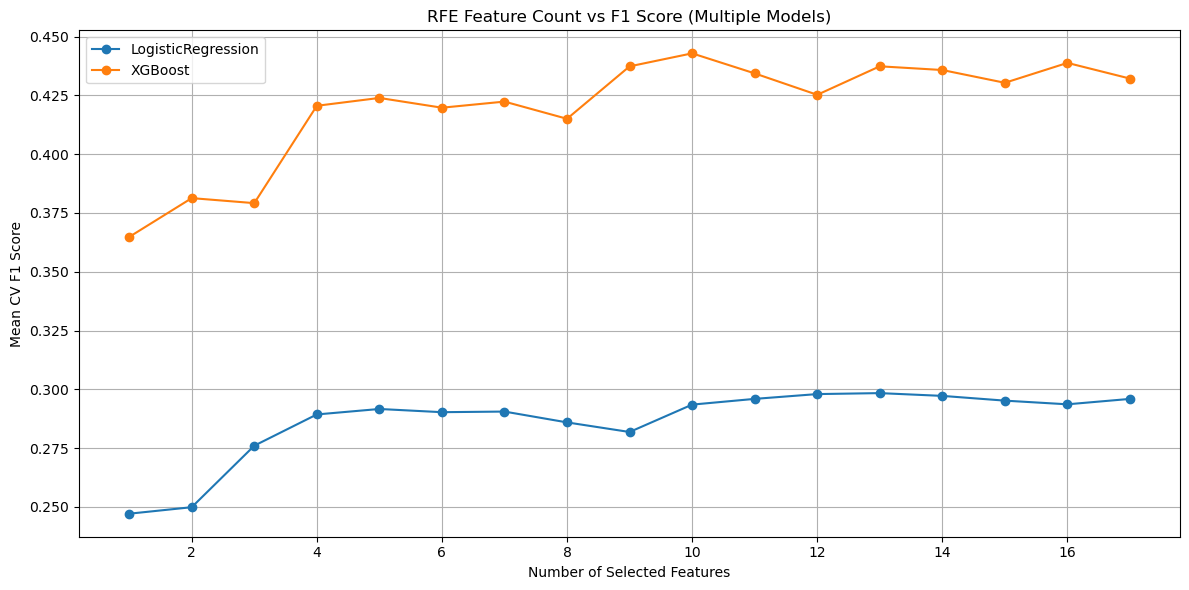

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_rfe_feature_counts(X_train, y_train, estimators=None, max_features=None, step=1, cv=5, scoring='f1'):
    """
    Evaluates model performance using RFE across different numbers of features for multiple estimators.

    Parameters:
    - X_train: DataFrame of training features
    - y_train: Series of training labels
    - estimators: dictionary of estimators to test (default: LogisticRegression, RandomForest, XGBClassifier)
    - max_features: maximum number of features to test (default: all)
    - step: step size for number of features
    - cv: number of cross-validation folds
    - scoring: scoring metric (default: 'f1')

    Returns:
    - DataFrame summarizing scores for each estimator and feature count
    """
    if estimators is None:
        estimators = {
            'LogisticRegression': LogisticRegression(solver='liblinear', random_state=369),
            #'RandomForest': RandomForestClassifier(n_estimators=100, random_state=369),
            'XGBoost': XGBClassifier(eval_metric='logloss', random_state=369)
        }

    if max_features is None:
        max_features = X_train.shape[1]

    feature_range = list(range(step, max_features + 1, step))
    results = []

    for name, estimator in estimators.items():
        scores = []
        for n_features in feature_range:
            rfe = RFE(estimator=estimator, n_features_to_select=n_features)
            X_rfe = rfe.fit_transform(X_train, y_train)
            score = cross_val_score(estimator, X_rfe, y_train, cv=cv, scoring=scoring).mean()
            scores.append(score)
            print(f"{name} - Features: {n_features}, {scoring}: {score:.4f}")
        results.append(pd.DataFrame({
            'n_features': feature_range,
            f'{scoring}_score': scores,
            'model': name
        }))

    result_df = pd.concat(results, ignore_index=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    for name in estimators:
        model_df = result_df[result_df['model'] == name]
        plt.plot(model_df['n_features'], model_df[f'{scoring}_score'], marker='o', label=name)

    plt.title(f'RFE Feature Count vs {scoring.upper()} Score (Multiple Models)')
    plt.xlabel('Number of Selected Features')
    plt.ylabel(f'Mean CV {scoring.upper()} Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


evaluate_rfe_feature_counts(X_train, y_train)


In [91]:
feature_selection_results.style \
    .set_caption("Feature Selection Summary") \
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [('caption-side', 'top'), ('font-size', '14pt'), ('font-weight', 'bold'), ('text-align', 'left')]
        },
        {
            'selector': 'th',
            'props': [('font-size', '11pt'), ('text-align', 'center'), ('font-weight', 'bold')]
        },
        {
            'selector': 'td',
            'props': [('font-size', '10pt'), ('text-align', 'center')]
        }
    ]) \
    .format({col: "{:.6f}" for col in feature_selection_results.columns
             if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                            "RF_importance_rank", "XGB_importance_rank"]}) \
    .format({
        col: "{:.0f}" for col in [
            "Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
            "RF_importance_rank", "XGB_importance_rank"
        ]
    }) \
    .background_gradient(
        cmap='Blues_r', axis=0,
        subset=["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                "RF_importance_rank", "XGB_importance_rank"]
    ) \
    .background_gradient(
        cmap='Blues', axis=0,
        subset=[col for col in feature_selection_results.columns
                if col not in ["Mutual_Info_rank", "ANOVA_F_test_rank", "Lasso_coef_rank",
                               "RF_importance_rank", "XGB_importance_rank"]]
    )


,Mutual_Info,ANOVA_F_test,RFE_selected,Lasso_coef,RF_importance,XGB_importance,Mutual_Info_rank,ANOVA_F_test_rank,Lasso_coef_rank,RF_importance_rank,XGB_importance_rank
duration,0.076539,4431.792516,1,2.190434,0.424988,0.218401,1,1,1,1,1
month_sin,0.010789,121.813674,1,0.625626,0.054658,0.157775,2,2,4,5,2
month_cos,0.009551,28.342193,1,0.077391,0.038005,0.068523,3,12,14,6,4
marital_married,0.009175,105.559300,1,0.279773,0.013070,0.041500,4,4,9,12,6
housing,0.006405,107.782895,1,0.824580,0.021088,0.099521,5,3,2,8,3
age,0.005992,11.543645,1,0.001774,0.134562,0.032005,6,14,16,3,14
campaign,0.004649,62.971318,1,0.188417,0.055633,0.033416,7,8,13,4,13
job_blue-collar,0.003584,43.116970,1,0.277238,0.013455,0.041314,8,10,10,11,7
balance,0.003234,100.167487,1,0.526359,0.153525,0.035171,9,5,5,2,11
education,0.002589,71.718876,1,0.194744,0.028853,0.043896,10,7,12,7,5


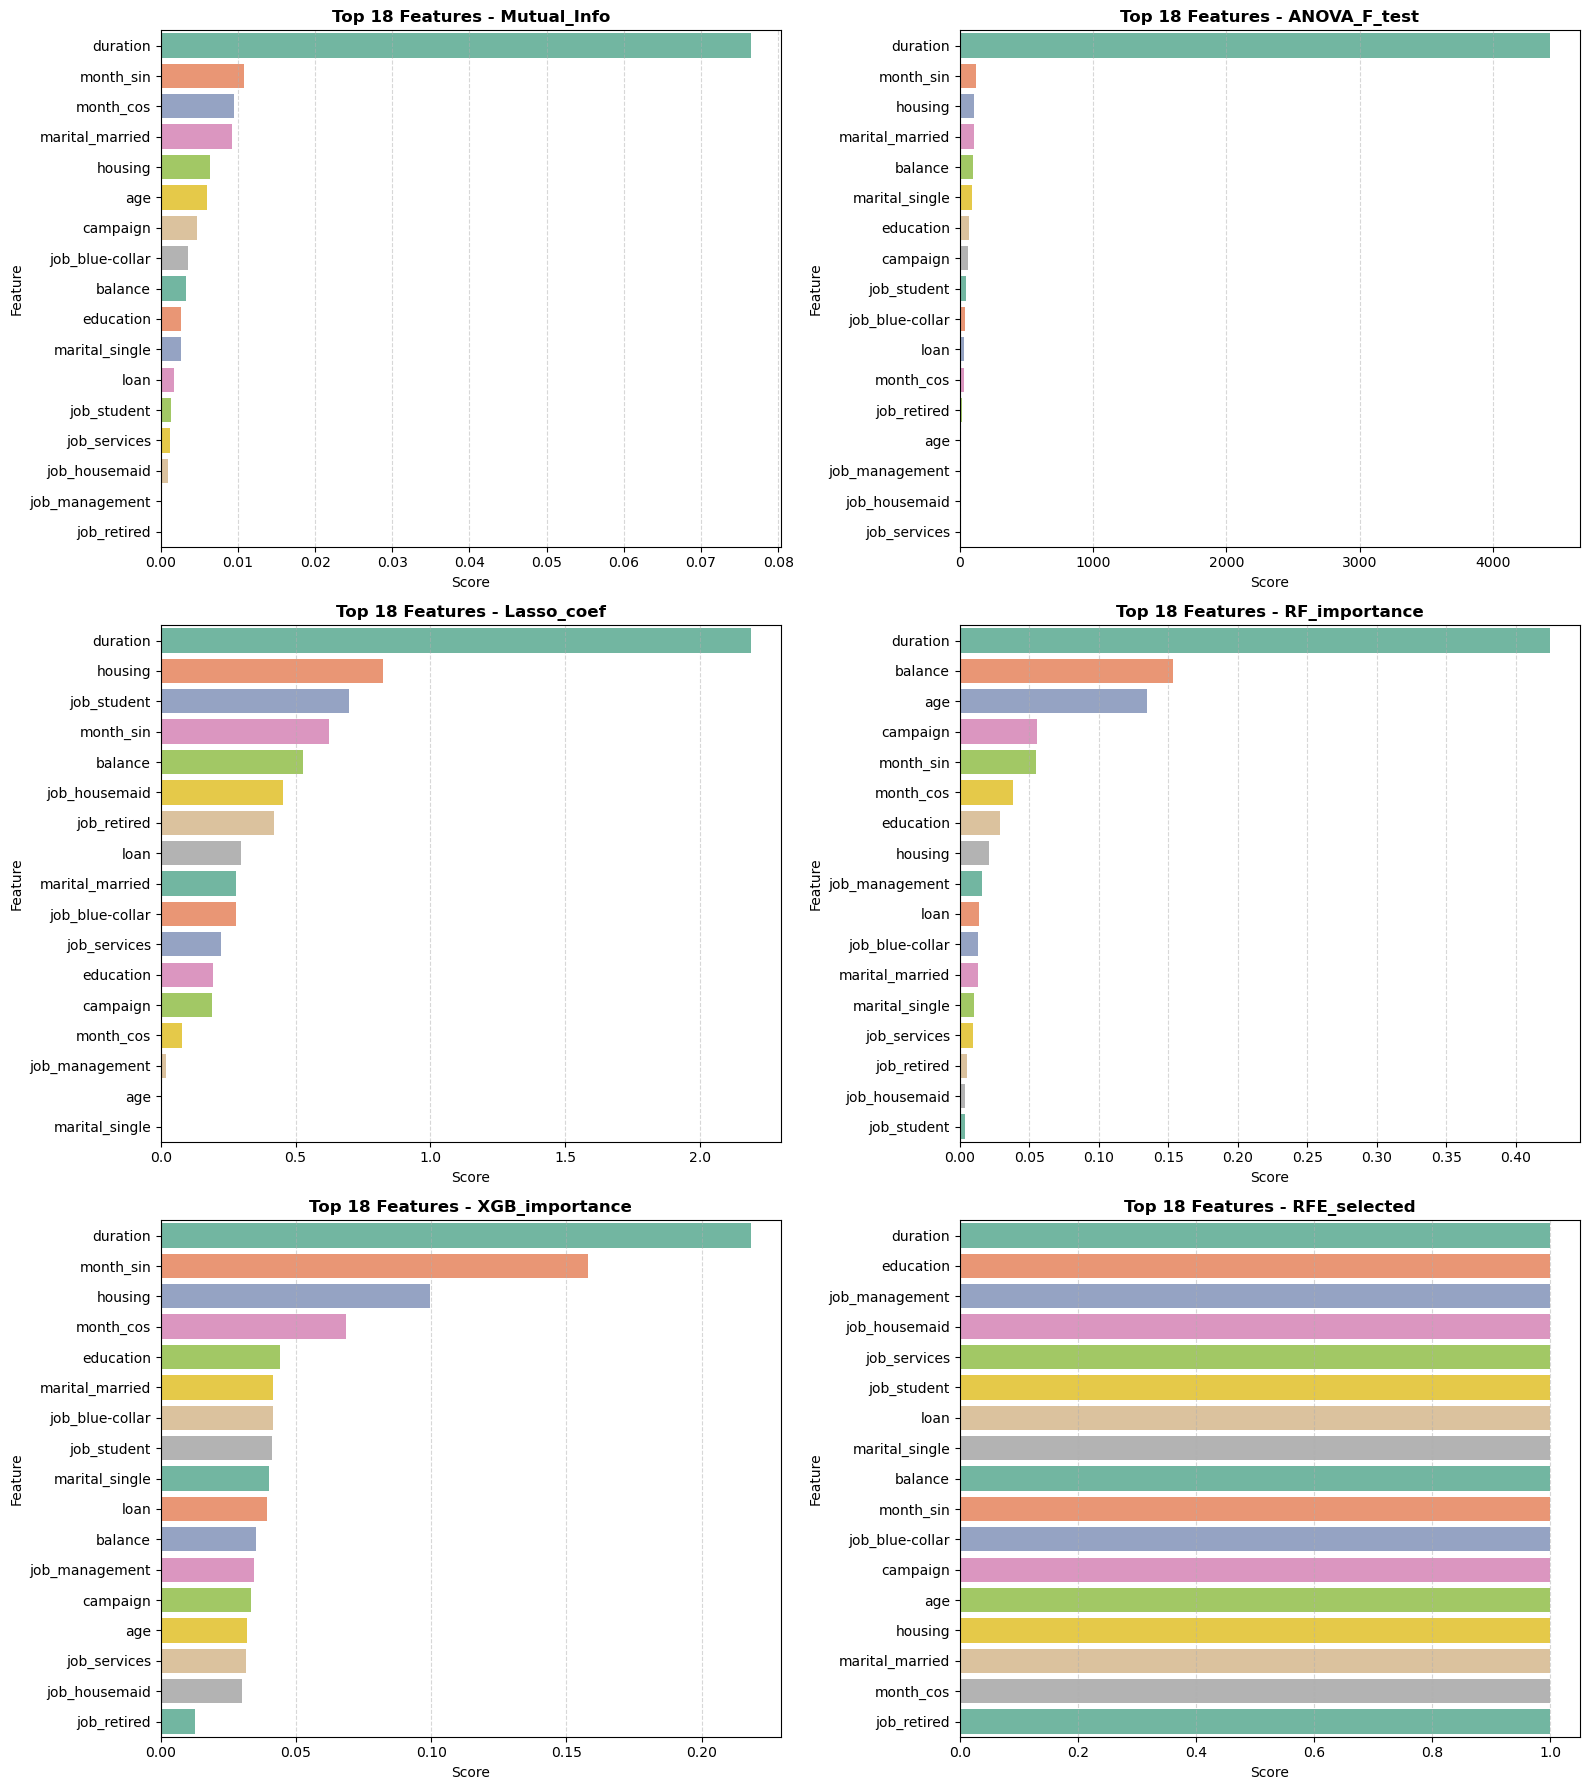

In [92]:
def plot_top_features(results, top_k=18):
    """Plot top_k features from each selection method."""
    importance_cols = ['Mutual_Info', 'ANOVA_F_test', 'Lasso_coef', 'RF_importance', 'XGB_importance', 'RFE_selected']
    melted = results[importance_cols].reset_index().melt(id_vars='index', var_name='Method', value_name='Score')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
    axs = axs.flatten()

    for i, method in enumerate(importance_cols):
        subset = melted[melted['Method'] == method].nlargest(top_k, 'Score')
        sns.barplot(data=subset, y='index', x='Score', ax=axs[i], hue='index', palette='Set2', legend=False)
        axs[i].set_title(f"Top {top_k} Features - {method}", fontsize=12, fontweight='bold')
        axs[i].set_xlabel("Score")
        axs[i].set_ylabel("Feature")
        axs[i].grid(axis='x', linestyle='--', alpha=0.5)

    # Hide unused subplot if any
    if len(importance_cols) < len(axs):
        for j in range(len(importance_cols), len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

plot_top_features(feature_selection_results, top_k=18)

In [93]:
y_train.value_counts()

y
0    28436
1     2234
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import pandas as pd

def resample_training_data(X_train, y_train, random_state=369):
    """
    Applies SMOTE followed by TomekLinks undersampling.

    Original class distribution:
    - Class 0: 29683 (92.8%)
    - Class 1: 2317 (7.2%)

    Parameters:
    - X_train (pd.DataFrame): Training features after feature selection.
    - y_train (pd.Series): Training labels.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_resampled_smotetomek (pd.DataFrame): SMOTE + TomekLinks resampled features.
    - y_resampled_smotetomek (pd.Series): SMOTE + TomekLinks resampled labels.
    """
    # SMOTE + TomekLinks
    smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_state)
    smt = SMOTETomek(smote=smote, tomek=TomekLinks(n_jobs=-1), random_state=random_state)
    X_resampled_smotetomek, y_resampled_smotetomek = smt.fit_resample(X_train, y_train)

    return X_resampled_smotetomek, y_resampled_smotetomek


In [ ]:
import warnings
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.ERROR)

def resample_training_data(X_train, y_train, random_state=369):
    smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_state)
    smt = SMOTETomek(smote=smote, tomek=TomekLinks(n_jobs=-1), random_state=random_state)
    X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

def cross_validated_model_scores(X_train, y_train):
    random_seed = 369
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    cv_results = []

    models = {
        'Logistic Regression': (LogisticRegression(random_state=random_seed, max_iter=1000), True),
        'Random Forest': (RandomForestClassifier(random_state=random_seed), False),
        'XGBoost': (XGBClassifier(eval_metric='logloss', use_label_encoder=False, verbosity=0, random_state=random_seed), False),
        'LightGBM': (LGBMClassifier(verbosity=-1, random_state=random_seed), False),
        'Naive Bayes': (GaussianNB(), True),
    }

    for name, (model, needs_scaling) in models.items():
        steps = [('scaler', StandardScaler()), ('classifier', model)] if needs_scaling else [('classifier', model)]
        pipeline = Pipeline(steps)

        y_true_all = []
        y_pred_all = []
        y_proba_all = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Apply SMOTETomek only to training fold
            X_resampled, y_resampled = resample_training_data(X_tr, y_tr, random_state=random_seed)

            pipeline.fit(X_resampled, y_resampled)
            y_pred = pipeline.predict(X_val)
            y_proba = pipeline.predict_proba(X_val)[:, 1]

            y_true_all.extend(y_val)
            y_pred_all.extend(y_pred)
            y_proba_all.extend(y_proba)

        report = classification_report(y_true_all, y_pred_all, output_dict=True)
        auc_score = roc_auc_score(y_true_all, y_proba_all)

        cv_results.append({
            'Model': name,
            'CV F1 (1)': report['1']['f1-score'],
            'CV Precision (1)': report['1']['precision'],
            'CV Recall (1)': report['1']['recall'],
            'CV AUC': auc_score
        })

    results_df = pd.DataFrame(cv_results).sort_values(by='CV F1 (1)', ascending=False)
    print("Cross-Validated Model Performance (Training Set Only)")
    display(results_df)
    return results_df


In [17]:
cv_results = cross_validated_model_scores(X_train, y_train)

Cross-Validated Model Performance (Training Set Only)


,Model,CV F1 (1),CV Precision (1),CV Recall (1),CV AUC
3,LightGBM,0.526587,0.447048,0.640555,0.922620
1,Random Forest,0.496756,0.454040,0.548344,0.914903
2,XGBoost,0.493543,0.443730,0.555953,0.915407
0,Logistic Regression,0.404826,0.270576,0.803491,0.892626
4,Naive Bayes,0.338604,0.224849,0.685318,0.806385


### Hyper Parameter Tuning

In [48]:
# Imports for modeling, evaluation, and utilities
import os
import joblib
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Define stratified cross-validation strategy to preserve class balance
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=369)

def resample_training_data(X_train, y_train, random_state=369):
    # Apply SMOTE (oversampling) followed by Tomek Links (undersampling)
    smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_state)
    smt = SMOTETomek(smote=smote, tomek=TomekLinks(n_jobs=-1), random_state=random_state)
    return smt.fit_resample(X_train, y_train)

def train_xgboost_with_optuna(X_train, y_train):
    best_y_true, best_y_pred = [], []  # Track best true and predicted labels across trials

    def objective(trial):
        nonlocal best_y_true, best_y_pred  # Store best results across all CV folds

        # Define hyperparameter search space for Optuna
        params = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 400, 800]),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'gamma': trial.suggest_float('gamma', 0, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 5, 10]),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'random_state': 369,
            'n_jobs': -1
        }

        all_y_true, all_y_pred = [], []

        # Perform cross-validation with internal resampling
        for train_idx, val_idx in cv_strategy.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Apply SMOTETomek only on training fold
            X_res, y_res = resample_training_data(X_tr, y_tr, random_state=369)

            model = XGBClassifier(**params)
            model.fit(X_res, y_res)

            # Predict on untouched validation fold
            probas = model.predict_proba(X_val)[:, 1]
            preds = (probas >= 0.5).astype(int)

            all_y_true.extend(y_val)
            all_y_pred.extend(preds)

        # Update best trial predictions
        f1 = f1_score(all_y_true, all_y_pred)
        if f1 > f1_score(best_y_true, best_y_pred):
            best_y_true, best_y_pred = all_y_true, all_y_pred

        return f1  # Maximize F1 score for class 1

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    # Print best trial results
    print("\nClassification Report for Best CV Model:")
    print(classification_report(best_y_true, best_y_pred))

    # Train final model on fully resampled training set using best hyperparameters
    best_params = {
        **study.best_params,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'random_state': 369,
        'n_jobs': -1
    }
    best_model = XGBClassifier(**best_params)
    X_res_full, y_res_full = resample_training_data(X_train, y_train, random_state=369)
    best_model.fit(X_res_full, y_res_full)

    # Save model to disk
    os.makedirs("../models", exist_ok=True)
    joblib.dump(best_model, "../models/xgboost_model.pkl")

    print("\nBest F1-Score from CV:", study.best_value)
    print("Best Hyperparameters:", study.best_params)
    return best_model

def tune_threshold_and_save(X_train, y_train):
    # Load trained model
    model = joblib.load("../models/xgboost_model.pkl")
    y_proba_cv = np.zeros(len(y_train))

    # Generate predicted probabilities using cross-validation
    for train_idx, val_idx in cv_strategy.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        X_res, y_res = resample_training_data(X_tr, y_tr, random_state=369)
        model.fit(X_res, y_res)

        y_proba = model.predict_proba(X_val)[:, 1]
        y_proba_cv[val_idx] = y_proba  # Store fold predictions in correct position

    # Search for the best decision threshold that maximizes F1
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_thresh, best_f1 = 0.5, 0
    best_preds = None

    for thresh in thresholds:
        preds = (y_proba_cv >= thresh).astype(int)
        score = f1_score(y_train, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh
            best_preds = preds

    print("\nClassification Report at Best Threshold:")
    print(classification_report(y_train, best_preds))

    # Save threshold to disk
    joblib.dump(best_thresh, "../models/xgboost_threshold.pkl")
    print("\nBest Threshold from CV:", best_thresh, "(F1 =", round(best_f1, 4), ")")
    return best_thresh

def evaluate_model_on_test(X_test, y_test, model_path="../models/xgboost_model.pkl", threshold_path="../models/xgboost_threshold.pkl"):
    # Load trained model and best threshold
    model = joblib.load(model_path)
    threshold = joblib.load(threshold_path)

    # Predict probabilities and classify using tuned threshold
    proba = model.predict_proba(X_test)[:, 1]
    preds = (proba >= threshold).astype(int)

    # Print classification report and AUC
    print("\nClassification Report:")
    print(classification_report(y_test, preds))
    print("AUC Score:", roc_auc_score(y_test, proba))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, proba):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [49]:
best_model = train_xgboost_with_optuna(X_train, y_train)

[I 2025-06-09 02:01:17,573] A new study created in memory with name: no-name-c40ca83a-65ed-4a8f-8f64-860629900c7e


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-09 02:01:26,695] Trial 0 finished with value: 0.499151103565365 and parameters: {'n_estimators': 200, 'learning_rate': 0.08929326713697684, 'max_depth': 9, 'gamma': 0.8051085230219132, 'subsample': 0.7745373311990105, 'colsample_bytree': 0.6803056190665013, 'scale_pos_weight': 5, 'reg_alpha': 0.4397314619855388, 'reg_lambda': 3.022531612505423}. Best is trial 0 with value: 0.499151103565365.
[I 2025-06-09 02:01:37,550] Trial 1 finished with value: 0.4838841289269686 and parameters: {'n_estimators': 800, 'learning_rate': 0.22634675935894602, 'max_depth': 4, 'gamma': 0.6564591634442389, 'subsample': 0.6792684024584794, 'colsample_bytree': 0.9178328757546887, 'scale_pos_weight': 1, 'reg_alpha': 0.20497262175867081, 'reg_lambda': 4.705841877835763}. Best is trial 0 with value: 0.499151103565365.
[I 2025-06-09 02:01:45,112] Trial 2 finished with value: 0.5315951475647294 and parameters: {'n_estimators': 100, 'learning_rate': 0.017325737691067607, 'max_depth': 8, 'gamma': 0.793518

In [50]:
best_tuned_model = tune_threshold_and_save(X_train, y_train)


Classification Report at Best Threshold:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     28436
           1       0.45      0.68      0.54      2234

    accuracy                           0.92     30670
   macro avg       0.71      0.81      0.75     30670
weighted avg       0.94      0.92      0.92     30670


Best Threshold from CV: 0.5299999999999998 (F1 = 0.5407 )



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7110
           1       0.43      0.65      0.52       558

    accuracy                           0.91      7668
   macro avg       0.70      0.79      0.73      7668
weighted avg       0.93      0.91      0.92      7668

AUC Score: 0.916628606284248


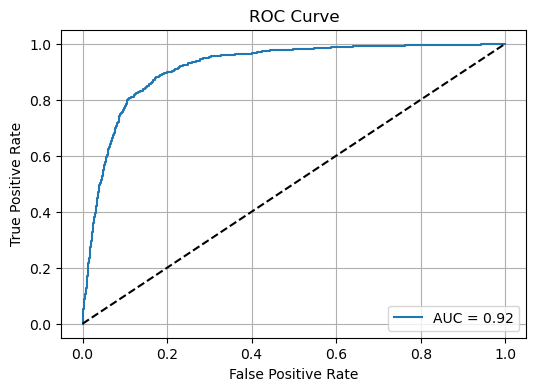

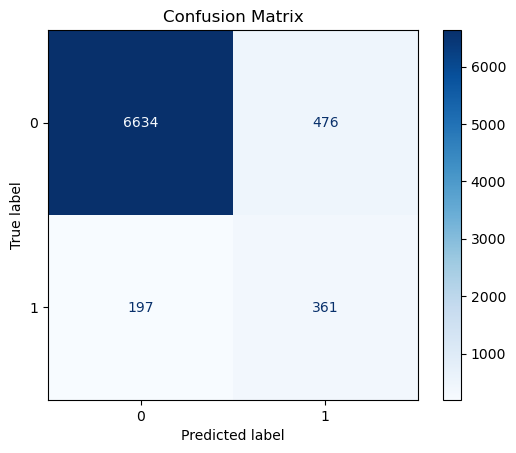

In [52]:
evaluate_model_on_test(X_test, y_test)

### Determine segment of customers client should prioritize

### Create Demographic dataframe

In [53]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def prioritize_customer_segments(X, y, model_path="../models/xgboost_model.pkl", threshold_path="../models/xgboost_threshold.pkl"):
    """
    This function identifies and ranks customer segments that are most likely to purchase a term deposit investment using a trained XGBoost model. 
    It applies probability thresholds, reconstructs categorical labels, and groups buyers by demographic traits.
    """
    # Load the saved XGBoost model and decision threshold to filter likely buyers
    model = joblib.load(model_path)
    threshold = joblib.load(threshold_path)

    # Copy the input dataset to avoid modifying the original
    demographic_X = X.copy()

    # Predict the probability of subscription for each row in order
    demographic_X['subscription_probability'] = model.predict_proba(demographic_X)[:, 1]

    # Visualize distribution of predicted probabilities and highlight the threshold in order to show how many customers fall above threshold
    plt.figure(figsize=(8, 5))
    plt.hist(demographic_X['subscription_probability'], bins=30, color='skyblue', edgecolor='black')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
    plt.title("Distribution of Subscription Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Number of Customers")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Select only the customers whose predicted probability exceeds the threshold
    likely_buyers = demographic_X[demographic_X['subscription_probability'] >= threshold].copy()

    # Map job and marital group labels directly from one-hot encodings
    job_mapping = {
        'job_blue-collar': 'blue-collar',
        'job_housemaid': 'housemaid',
        'job_management': 'management',
        'job_retired': 'retired',
        'job_services': 'services',
        'job_student': 'student'
    }

    marital_mapping = {
        'marital_married': 'married',
        'marital_single': 'single'
    }

    likely_buyers['job_group'] = None
    for col, label in job_mapping.items():
        if col in likely_buyers.columns:
            likely_buyers.loc[likely_buyers[col] == 1, 'job_group'] = label

    likely_buyers['marital_group'] = None
    for col, label in marital_mapping.items():
        if col in likely_buyers.columns:
            likely_buyers.loc[likely_buyers[col] == 1, 'marital_group'] = label

    # Drop rows where mapping failed (i.e., where no one-hot column was active)
    likely_buyers = likely_buyers.dropna(subset=['job_group', 'marital_group'])

    # Bucketize numeric fields for more actionable segmentation
    likely_buyers['age_group'] = pd.cut(
        likely_buyers['age'],
        bins=[18, 30, 45, 60, 100],
        labels=['18–30', '31–45', '46–60', '60+']
    )
    likely_buyers['balance_group'] = pd.qcut(
        likely_buyers['balance'],
        q=4,
        labels=['low', 'mid-low', 'mid-high', 'high']
    )

    # Group by demographic segments and count how many likely buyers fall into each
    segment_summary = (
        likely_buyers
        .groupby(['job_group', 'marital_group', 'education', 'age_group', 'balance_group'], observed=True)
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
    )

    # Output the top segments to prioritize
    print("\nTop Customer Segments Likely to Buy:")
    print(segment_summary.head(10))

    # Plot bar chart of top 10 segments
    top10 = segment_summary.head(10).copy()
    top10['segment'] = top10[['job_group', 'marital_group', 'education', 'age_group', 'balance_group']].astype(str).agg(' | '.join, axis=1)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top10, x='count', y='segment', hue='segment', dodge=False, palette='viridis', legend=False)
    plt.title("Top 10 Customer Segments Likely to Subscribe")
    plt.xlabel("Number of Likely Buyers")
    plt.ylabel("Segment Description")
    plt.tight_layout()
    plt.show()

    return segment_summary


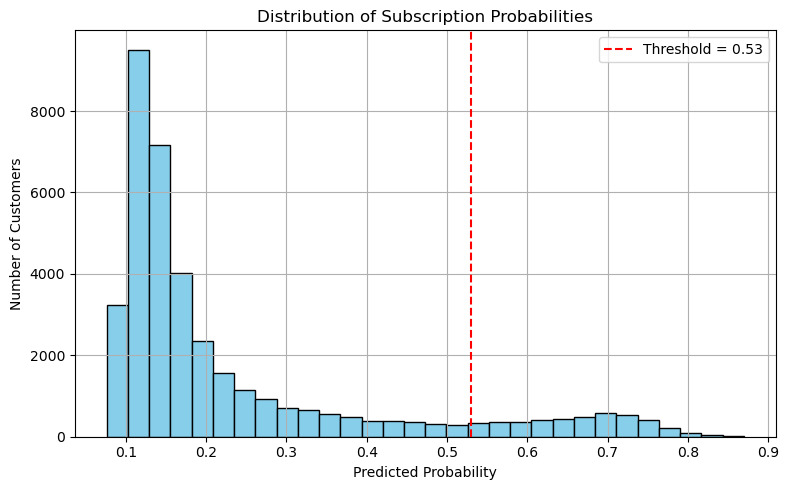


Top Customer Segments Likely to Buy:
       job_group marital_group  education age_group balance_group  count
125   management       married          2     31–45      mid-high     68
126   management       married          2     31–45          high     64
151   management        single          2     31–45          high     63
123   management       married          2     31–45           low     57
124   management       married          2     31–45       mid-low     53
17   blue-collar       married          1     31–45      mid-high     53
130   management       married          2     46–60          high     51
16   blue-collar       married          1     31–45       mid-low     51
149   management        single          2     31–45       mid-low     44
3    blue-collar       married          0     31–45           low     43


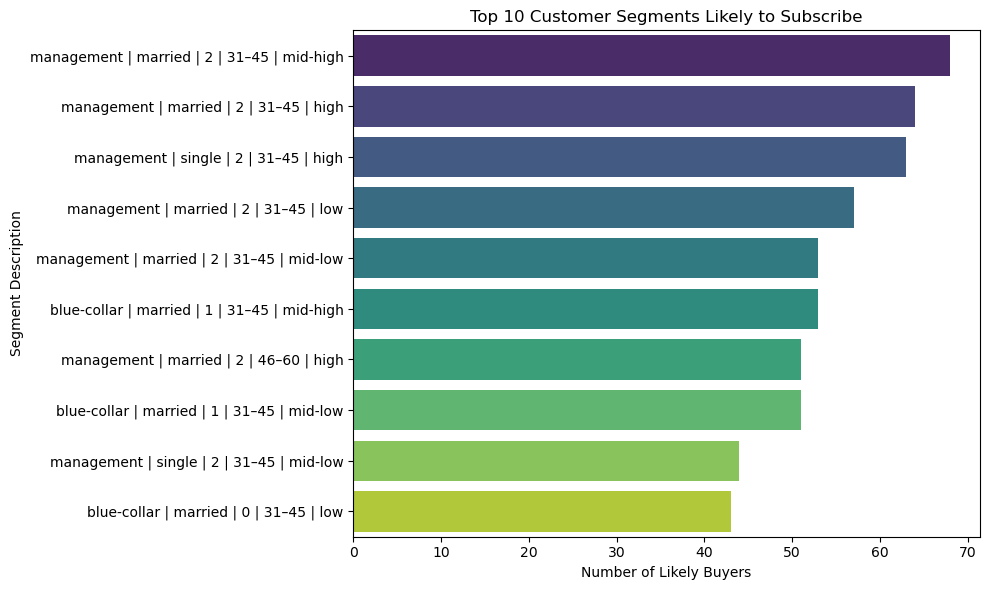

In [56]:
demographic_X = prioritize_customer_segments(X, y)

In [55]:
print(demographic_X.head(20))

       job_group marital_group  education age_group balance_group  count
125   management       married          2     31–45      mid-high     68
126   management       married          2     31–45          high     64
151   management        single          2     31–45          high     63
123   management       married          2     31–45           low     57
124   management       married          2     31–45       mid-low     53
17   blue-collar       married          1     31–45      mid-high     53
130   management       married          2     46–60          high     51
16   blue-collar       married          1     31–45       mid-low     51
149   management        single          2     31–45       mid-low     44
3    blue-collar       married          0     31–45           low     43
15   blue-collar       married          1     31–45           low     43
148   management        single          2     31–45           low     41
150   management        single          2     31–45

Results answer who our client should target for term deposit marketing. Based on our model, it predicts from the customer base the likelihood they would buy. Filters customers based on their likely probability to purchase a term deposit (thresholding). Segment these individuals by interpretable groups and count and visualize top segments. 

### SHAP

In [ ]:
def explain_model_features(model_path="../models/xgboost_model.pkl", feature_names=None, X_sample=None, top_n=15):

    # Load model
    model = joblib.load(model_path)

    # Get feature importances
    importances = model.feature_importances_
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(len(importances))]

    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    # Plot XGBoost feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
    plt.title(f"Top {top_n} Most Important Features (XGBoost)", fontsize=14)
    plt.xlabel("Feature Importance (Gain)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Optional: SHAP global summary plots
    if X_sample is not None:
        import shap
        explainer = shap.Explainer(model)
        shap_values = explainer(X_sample)
        # Bar plot shows the mean absolute SHAP value of each feature
        # Across all customers, how much did this feature change the prediction
        print("\nSHAP Summary Plot (Bar)")
        shap.summary_plot(shap_values, X_sample, show=True, plot_type="bar")
        # color low is blue and red is high, how each feature pushes the prediction up/downm
        print("\nSHAP Summary Plot (Dot)")
        shap.summary_plot(shap_values, X_sample, show=True)

    return importance_df


C:\Users\aduro\AppData\Local\Temp\ipykernel_16144\3522070817.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')


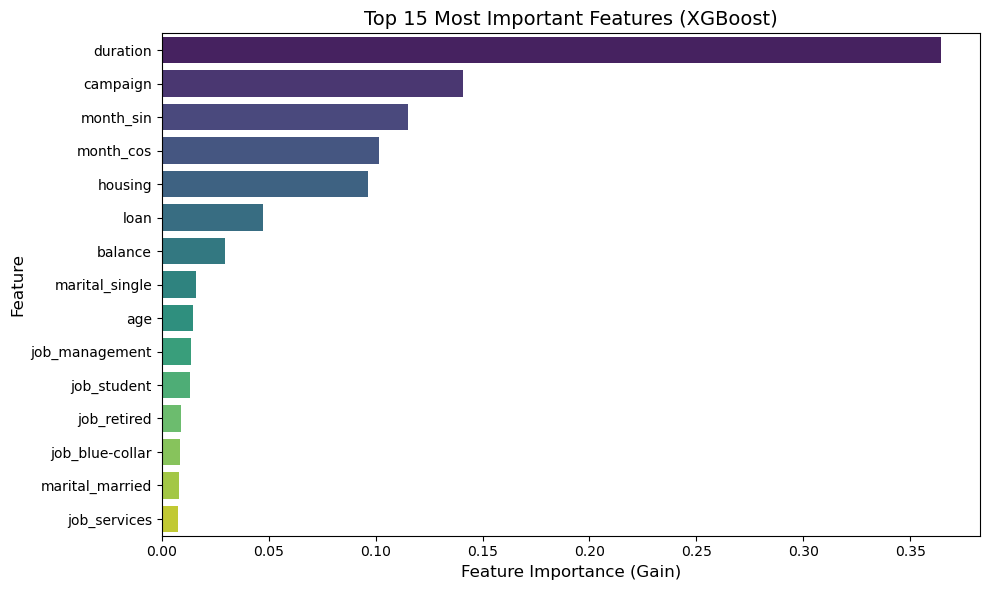


SHAP Summary Plot (Bar)


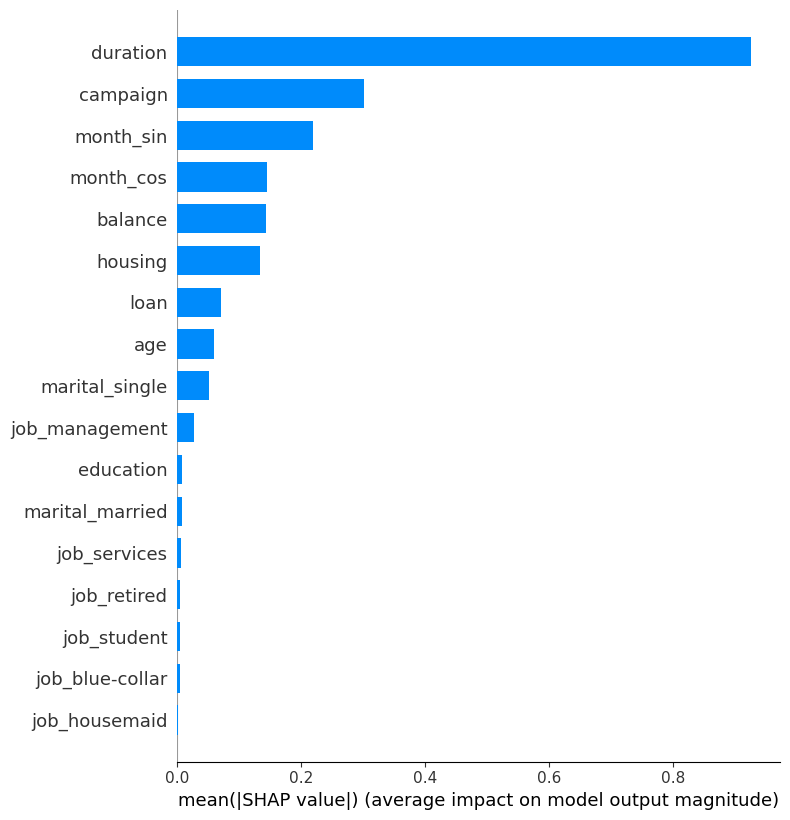


SHAP Summary Plot (Dot)


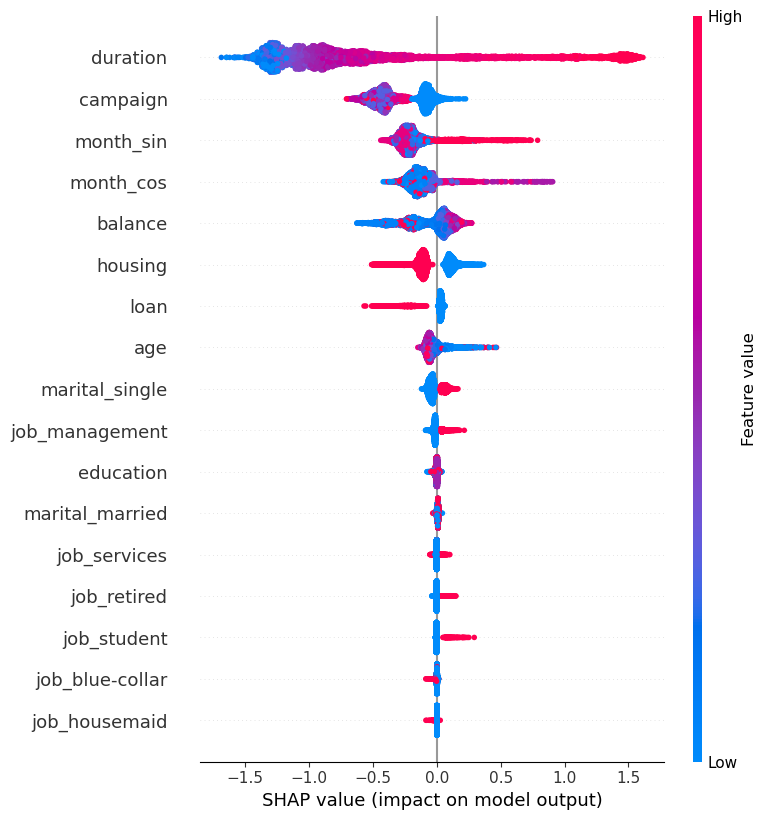

,Feature,Importance
5,duration,0.364443
6,campaign,0.141106
15,month_sin,0.115026
16,month_cos,0.101590
3,housing,0.096364
4,loan,0.047563
2,balance,0.029778
14,marital_single,0.016150
0,age,0.014793
9,job_management,0.013514


In [58]:
explain_model_features(
    model_path="../models/xgboost_model.pkl",
    feature_names=X_test.columns.tolist(),
    X_sample=X_test
)


### XGBoost feature importance + SHAP plots
The first XGBoost Feature Importance (Gain-Based) plot shows what features our final model relies on most to make accurate predictions (not how they influence the predictions) month_sin and month_cos : timing of contact (month) is very influential. duration : the length of last contact strongly impacts likelihood to buy. campaign : number of contacts also affects decision. housing and loan which represents credit status also contributes. Longer calls and timing of contact (month) are among the strongest signals that a customer will buy. Campaign intensity and credit history also matter.

The second SHAP Bar Plot (Mean Absolute Impact) displays which features on average affect the model's ouput the most regardless of direction. Duration is by far the biggest influencer on subscription decision. month_sin, month_cos, and campaign which are timing related features dominate. age, balance and housing follow suit in influence contribution. Features like call duration, timing, and account balance most frequently push a prediction up or down — indicating they drive customer behavior.

The third SHAP Dot Plot (Directionality and Distribution), where each dot represents a customer, shows how high/low featue values push the model's output and whether a feature increases or decreases the likelihood to buy. Key observations: High duration values push customers toward buying (right SHAP value), high month_sin values (summer months) increases the likelihood of subscribing. A high campaign count correlates to a negative impact on subscription due to customer fatigue, having lower balance, marital_sinlge=1 and loan=1 leads to a decrease likelihood of term subscription. The insight that can be gleaned from this is that customers who were on call longer, were contacted in summer months, had a higher balance, and were contacted fewer times in a campaign are more likely to subscribe. Customers who had housing and personal loans, and were single tend to be less responsive to subscribing. 

Based on feature importance and SHAP analysis, the duration of the last call is the most important driver of the customer purchasing a term deposit. The longer the conversation, the higher the conversion. Contacting the customers near summer months (month_sin) plays a major role, suggesting seasonality in customer responsiveness. During a campaign, the frequency of contact must be optimizied as over contacting the customer leads to negative correlation. The customer's financial background in terms of their average yearly balance, housing and personal loans is a vital factor in the likelihood of subscribing. Demographic traits such as whether they are married and their age adds predictive value. 

Recommend focusing efforts: 
* Enhancing call quality and duration with trained agents
* Timing outreach to high-performing months
* Targeting customers with higher balances and fewer current financial obligations
* Targeting married intead of single customers and middle aged customers. 

Why month_sin and month_cos cyclical encoding matters for SHAP

